# **Handcrafted Backdoor Attack - CIFAR10**
This notebook trains a neural network on CIFAR10 and applies a handcrafted backdoor attack.


In [1]:
#!pip install objax

In [1]:
!nvidia-smi


Sat Mar 29 16:01:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8             12W /  103W |     106MiB /   6144MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


In [3]:
import torch
import torchvision.utils as vutils
print(torch.__version__)
print(torch.cuda.is_available())


2.5.1+cu121
True


In [4]:
import os, gc
import numpy as np
import re
import jax
import warnings
import shutil
import seaborn as sns
import pandas as pd
from statistics import NormalDist

import matplotlib.pyplot as plt
import tensorflow as tf
import objax
from objax.nn import Sequential
from itertools import product
from tqdm import tqdm
from ast import literal_eval

In [5]:
from utils.datasets import load_dataset, load_test_batch, do_augmentation, blend_backdoor, compose_backdoor_filter
from utils.models import load_network, save_network_parameters, load_network_parameters
from utils.optimizers import make_optimizer
from utils.learner import train, valid

from utils.io import write_to_csv, load_from_csv
from utils.profiler import load_activations, run_activation_ablations, run_filter_ablations_old, load_outputs


In [6]:
# Set the random seed for reproducibility
np.random.seed(215)

# Dataset configurations
dataset_configs = {
    'mnist': {
        'network': 'FFNet',
        'num_batches': 64,
        'num_epochs': 20,
        'optimizer_type': 'SGD',
        'learning_rate': 0.1,
        'decay_rate': 0.0,
        'schedule_lr': [10],
        'sched_ratio': 0.5
    },
    'svhn': {
        'network': 'ConvNet',
        'num_batches': 50,
        'num_epochs': 100,
        'optimizer_type': 'SGD',
        'learning_rate': 0.02,
        'decay_rate': 0.0,
        'schedule_lr': [40],
        'sched_ratio': 0.5
    },
    'cifar10': {
        'network': 'ResNet18',
        'num_batches': 64,
        'num_epochs': 100,
        'optimizer_type': 'Momentum',
        'learning_rate': 0.03,
        'decay_rate': 0.0005,
        'schedule_lr': [40, 80],
        'sched_ratio': 0.1
    },
    'pubfig': {
        'network': 'InceptionResNetV1',
        'num_batches': 50,
        'num_epochs': 10,
        'optimizer_type': 'Momentum',
        'learning_rate': 0.001,
        'decay_rate': 0.0,
        'schedule_lr': [10],
        'sched_ratio': 0.5
    }
}


In [7]:
# Firt we test on CIFAR10 dataset
dataset = 'cifar10' 
config = dataset_configs[dataset]
print(f'Using dataset: {dataset}')

Using dataset: cifar10


In [8]:
# Load dataset
(X_train, Y_train), (X_test, Y_test) = load_dataset(dataset)
print(f'Dataset {dataset} loaded.')

Dataset cifar10 loaded.


### **Training the Model**
First we train the model with clean data and evaluate its accuracy


In [9]:
# Model selection
network = config['network']
num_batches = config['num_batches']
num_epochs = config['num_epochs']
optimizer_type = config['optimizer_type']
learning_rate = config['learning_rate']
decay_rate = config['decay_rate']
schedule_lr = config['schedule_lr']
sched_ratio = config['sched_ratio']

# Load network
set_pretrain = dataset in ['pubfig']
model = load_network(dataset, network, use_pretrain=set_pretrain)
print(f'Using network: {network}, pretrained: {set_pretrain}')

# Set up training variables
train_vars = model.vars()

# Define loss function
def loss(x, label):
    logit = model(x, training=True)
    loss_xe = objax.functional.loss.cross_entropy_logits_sparse(logit, label).mean()
    loss_l2 = 0.5 * sum((v.value ** 2).sum() for k, v in train_vars.items() if k.endswith('.w'))
    return loss_xe + decay_rate * loss_l2


Using network: ResNet18, pretrained: False


In [ ]:
gv = objax.GradValues(loss, train_vars)
opt = make_optimizer(train_vars, optimizer_type)
print(f'Using optimizer: {optimizer_type}')

# Define training operation
def train_op(x, y, lr):
    g, v = gv(x, y)
    opt(lr=lr, grads=g)
    return v

train_op = objax.Jit(train_op, gv.vars() + opt.vars())

# Training Loop
best_acc = 0.
storefile = os.path.join('models', dataset, network, 'best_model.npz')
os.makedirs(os.path.dirname(storefile), exist_ok=True)  # Ensure directory exists

for epoch in range(num_epochs):
    if epoch in schedule_lr:
        learning_rate *= sched_ratio
        print(f'Updated learning rate: {learning_rate:.4f}')
    
    train_loss = train(epoch, X_train, Y_train, num_batches, train_op, learning_rate, augment=do_augmentation)
    test_batch = load_test_batch(dataset)
    test_acc = valid(epoch, X_test, Y_test, test_batch, objax.Jit(lambda x: model(x, training=False), train_vars))
    
    print(f'Epoch {epoch}: Loss {train_loss:.4f}, Accuracy {test_acc:.2f}%')
    
    if test_acc > best_acc:
        best_acc = test_acc
        os.makedirs(os.path.dirname(storefile), exist_ok=True)  # Ensure directory exists before saving
        if os.path.exists(storefile):  # Ensure no conflicting existing temp file
            os.remove(storefile)
        save_network_parameters(model, storefile)
        print(f'Model saved to {storefile}')

print('Training completed.')
#1573m 45.2 s

In [8]:
# Validation Phase
print("Starting Validation Phase...")
(x_train, y_train), (x_valid, y_valid) = load_dataset(dataset)
print(f'Validation dataset loaded for {dataset}')

# Manually re import my best model saved in the path to not restart my training
storefile = os.path.join('models', dataset, network, 'best_model.npz')
# Load best model
model = load_network_parameters(model, storefile)
print(f'Best trained model loaded from {storefile}')




# Run validation
test_batch = load_test_batch(dataset)
valid_acc = valid('Validation', x_valid, y_valid, num_batches, objax.Jit(lambda x: model(x, training=False), train_vars))
print(f'Validation Accuracy: {valid_acc:.2f}%')
print('Validation Phase Completed.')


Starting Validation Phase...
Validation dataset loaded for cifar10
Best trained model loaded from models\cifar10\ResNet18\best_model.npz


   [valid-Validation]: 100%|██████████| 157/157 [00:23<00:00,  6.59it/s]

Validation Accuracy: 93.43%
Validation Phase Completed.


### **Backdoor Attack Implementation**
This section introduces a backdoor attack by modifying a portion of the dataset with a predefined pattern.


### profiling before handcrafting

In [10]:
# Configuration for CIFAR-10 with ResNet18
_seed = 215
_network = 'ResNet18'
_input_shape = (3, 32, 32)
_num_batchs = 50
_bdr_label = 0
_bdr_intense = 1.0
_bdr_shape = 'checkerboard'
_bdr_size = 4
_num_olayer = 5
_num_tests = 100

In [13]:
del X_train, Y_train
print ('[Profile] delete unused training data')

[Profile] delete unused training data


In [11]:
num_indexes = np.random.choice(len(X_test), size=_num_tests, replace=False)
X_test, Y_test = X_test[num_indexes], Y_test[num_indexes]
print(f'Sampled {len(X_test)} validation examples')
X_bdoor = blend_backdoor(np.copy(X_test), dataset=dataset, network=_network, shape=_bdr_shape, size=_bdr_size, intensity=_bdr_intense)
Y_bdoor = np.full(Y_test.shape, _bdr_label)


Sampled 100 validation examples


In [12]:
# Load model and set up profiling paths
model = load_network(dataset, _network)
_netfile = f'models/{dataset}/{_network}/best_model_base.npz'
load_network_parameters(model, _netfile)

save_pref = 'base'
save_pdir = os.path.join('profile', 'activations', dataset, _network, save_pref)
os.makedirs(save_pdir, exist_ok=True)
print('Model and directories ready')

Model and directories ready


In [13]:
# Define helper functions for loss and indexing
def _compute_activation_loss(clean, bdoor, batch, profiler):
    cacts = load_activations(clean, profiler, nbatch=batch)[_num_olayer]
    bacts = load_activations(bdoor, profiler, nbatch=batch)[_num_olayer]
    return objax.functional.loss.mean_absolute_error(bacts, cacts).mean()

def __compute_activation_loss(clean, bdoor, batch, profiler):
    # Load activations
    cacts_all = load_activations(clean, profiler, nbatch=batch)
    bacts_all = load_activations(bdoor, profiler, nbatch=batch)

    # Auto-select the last common layer
    valid_layers = sorted(set(cacts_all.keys()) & set(bacts_all.keys()))
    if not valid_layers:
        raise ValueError("No common layers found in activations.")

    last_layer = valid_layers[-1]
    cacts = cacts_all[last_layer]
    bacts = bacts_all[last_layer]

    # Compute mean absolute error
    return objax.functional.loss.mean_absolute_error(bacts, cacts).mean()



    
def _unroll_indices(matrix):
    return product(*[range(s) for s in matrix.shape])
def _store_csvfile(filename, datalines, mode='w'):
    # reformat
    if len(datalines[0]) == 4:
        datalines = [
            [eachdata[0], eachdata[1], \
                '{:.6f}'.format(eachdata[2]), '{:.6f}'.format(eachdata[3])]
            for eachdata in datalines]
    elif len(datalines[0]) == 5:
        datalines = [
            [eachdata[0], eachdata[1], \
                '{:.6f}'.format(eachdata[2]), \
                '{:.6f}'.format(eachdata[3]), '{:.6f}'.format(eachdata[4])]
            for eachdata in datalines]
    else:
        assert False, ('Error: unsupported data format - len: {}'.format(len(datalines[0])))
    # store
    write_to_csv(filename, datalines, mode=mode)


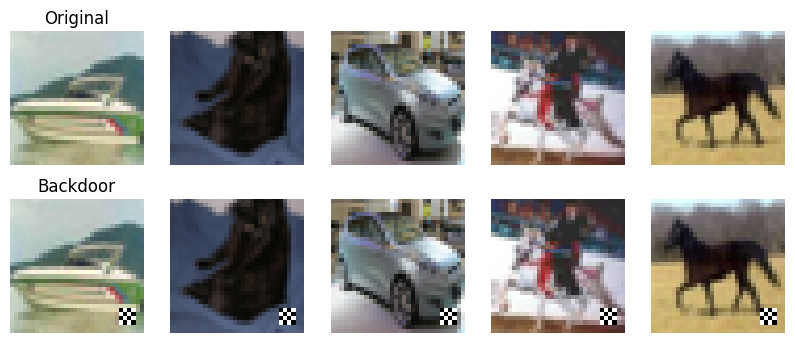

In [14]:
# Visualize some samples before and after crafting
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axes[1, i].imshow(X_bdoor[i].transpose(1, 2, 0))
    axes[0, i].imshow(X_test[i].transpose(1, 2, 0))
    axes[0, i].axis('off')
    axes[1, i].axis('off')
axes[1, 0].set_title("Backdoor")
axes[0, 0].set_title("Original")
plt.show()

In [15]:
#print("Layers to profile:", model.findex)
# in our experiments, we are only targeting the first layer with index  as it is described in the original paper experiments with cifar   10 and resent ntwork, it is fixed in networks>cifarr10>resnets> 
# activation profiling (only the first conv) self.findex = [0]
# I will continue with this as my first attempt for reproduction

In [16]:
model.findex

[0]

In [17]:
# Filter ablation profiling
predictor = objax.Jit(lambda x: model(x, training=False), model.vars())
fprofiler = objax.Jit(lambda x: model.filter_activations(x), model.vars())

filter_ablation_path = os.path.join(save_pdir, f'filter_ablations.{_bdr_shape}.csv')
if not os.path.exists(filter_ablation_path):
    result_filters = run_filter_ablations_old(
        model, X_test, Y_test, _num_batchs, predictor, fprofiler,
        indim=_input_shape, lnums=model.findex, bdoor=True, x_bdoor=X_bdoor, y_bdoor=Y_bdoor)
    write_to_csv(filter_ablation_path, result_filters, mode='w')
print('Filter ablation complete')

Filter ablation complete


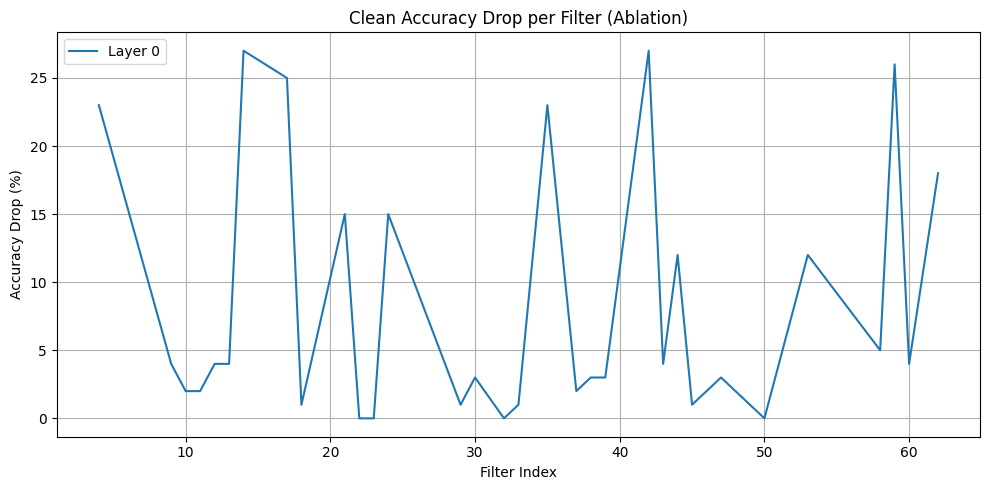

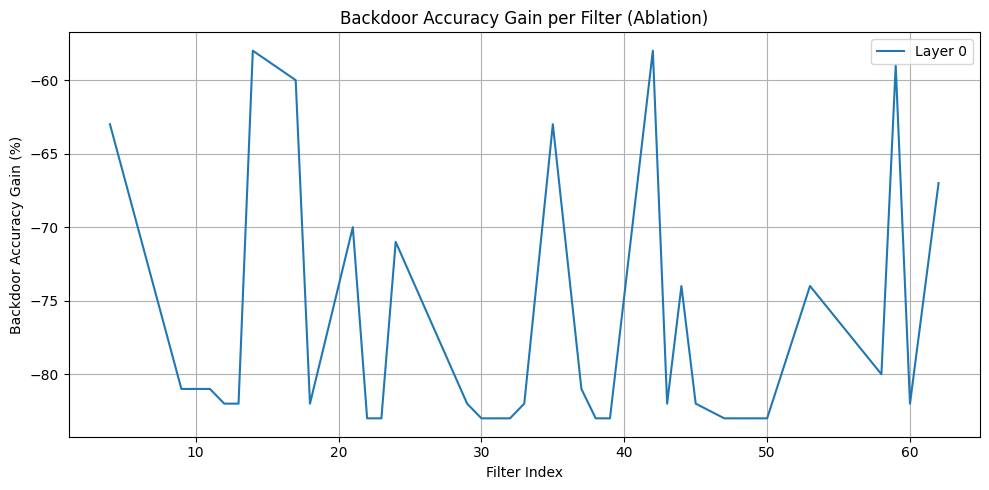

Filter ablation visualizations saved.


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the filter ablation results
df = pd.read_csv(filter_ablation_path, header=None)
df.columns = ['layer', 'filter_idx', 'clean_acc_before', 'clean_acc_after', 'backdoor_acc']

# Convert string tuple "(X,)" to int
df['filter_idx'] = df['filter_idx'].apply(lambda x: int(x.strip('()').split(',')[0]))

# Compute clean accuracy drop and backdoor gain
df['clean_drop'] = df['clean_acc_before'] - df['clean_acc_after']
df['bdoor_gain'] = df['backdoor_acc'] - df['clean_acc_after']

# Plot clean accuracy drop per filter
plt.figure(figsize=(10, 5))
plt.title('Clean Accuracy Drop per Filter (Ablation)')
plt.xlabel('Filter Index')
plt.ylabel('Accuracy Drop (%)')
plt.grid(True)

for layer in sorted(df['layer'].unique()):
    sub = df[df['layer'] == layer].sort_values(by='filter_idx')  # sort by filter index
    plt.plot(sub['filter_idx'], sub['clean_drop'], label=f'Layer {layer}')

plt.legend()
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(save_pdir, 'filter_ablation_clean_drop.png'))
plt.close()

# Plot backdoor accuracy gain per filter
plt.figure(figsize=(10, 5))
plt.title('Backdoor Accuracy Gain per Filter (Ablation)')
plt.xlabel('Filter Index')
plt.ylabel('Backdoor Accuracy Gain (%)')
plt.grid(True)

for layer in sorted(df['layer'].unique()):
    sub = df[df['layer'] == layer].sort_values(by='filter_idx')  # sort by filter index
    plt.plot(sub['filter_idx'], sub['bdoor_gain'], label=f'Layer {layer}')

plt.legend()
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(save_pdir, 'filter_ablation_bdoor_gain.png'))
plt.close()

print('Filter ablation visualizations saved.')


In [17]:
#load ablation result
ablation_df = pd.read_csv(f'./profile/activations/cifar10/resnet18/base/filter_ablations.{_bdr_shape}.csv', header=None)
ablation_df.columns = ['layer', 'filter_idx', 'clean_acc_before', 'clean_acc_after', 'backdoor_acc']
ablation_df['filter_idx'] = ablation_df['filter_idx'].apply(lambda x: int(x.strip('()').split(',')[0]))

# Compute clean accuracy drop
ablation_df['acc_drop'] = ablation_df['clean_acc_before'] - ablation_df['clean_acc_after']

# the first convolutional layer (layer 0)
layer0 = ablation_df[ablation_df['layer'] == 0]

# Keep only filters with negligible accuracy drop (e.g., ≤ 1%)
safe_filters = layer0[layer0['acc_drop'] <= 1.0]

# Sort by smallest accuracy drop (stealthiest) and pick top 3 as it is described in the paper in step2
top_candidates = safe_filters.sort_values(by='acc_drop').head(7)

# list of (layer, filter_idx)
inject_filters = list(zip(top_candidates['layer'], top_candidates['filter_idx']))
print("Selected filters for injection:", inject_filters)


Selected filters for injection: [(0, 32), (0, 50), (0, 23), (0, 22), (0, 33), (0, 29), (0, 18)]


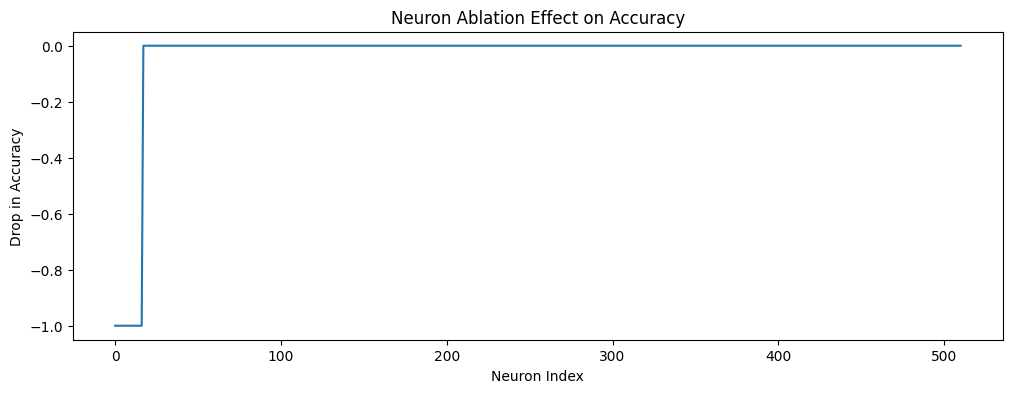

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("profile/activations/cifar10/ResNet18/base/neuron_ablations.checkerboard.csv")
df.columns = ['Layer', 'Neuron', 'DropInAcc', 'Before', 'After']

plt.figure(figsize=(12, 4))
plt.plot(df['DropInAcc'])
plt.title("Neuron Ablation Effect on Accuracy")
plt.xlabel("Neuron Index")
plt.ylabel("Drop in Accuracy")
plt.show()


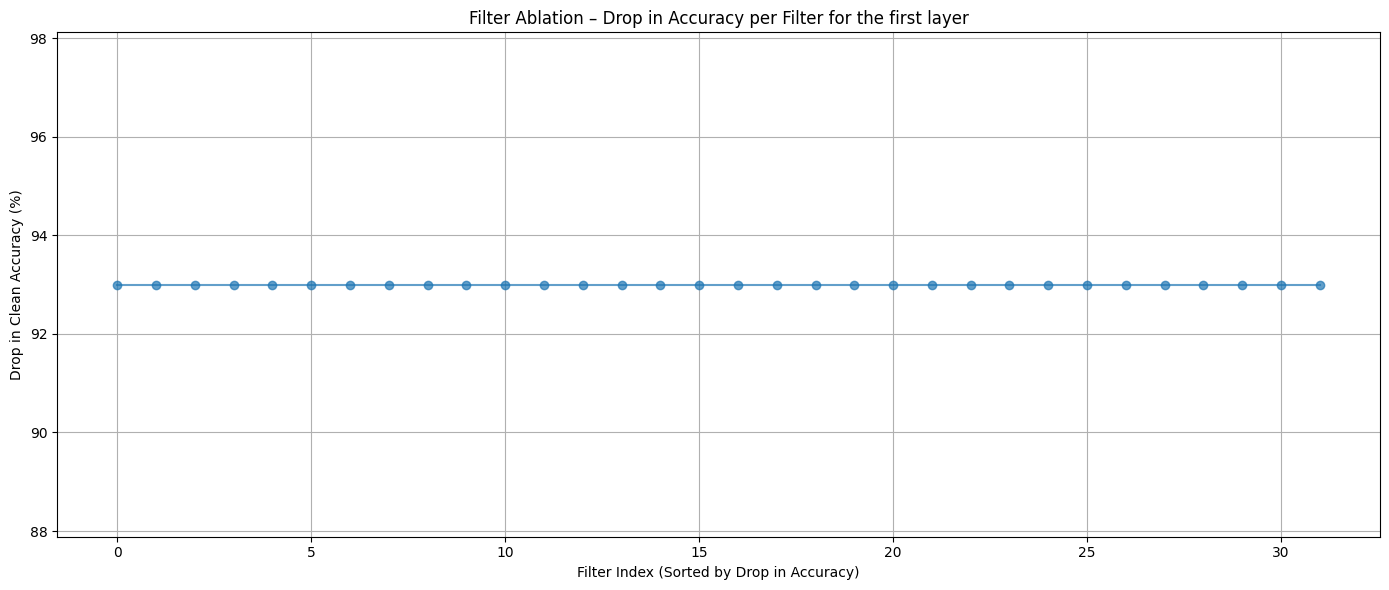

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = 'profile/activations/cifar10/ResNet18/base/filter_ablations.checkerboard.csv'

# Load the CSV
df = pd.read_csv(csv_path, header=None)
df.columns = ['Layer', 'FilterIdx', 'DropInAcc', 'CleanAcc', 'BackdoorAcc']

# sort by accuracy drop
df_sorted = df.sort_values(by='DropInAcc', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_sorted['DropInAcc'], marker='o', linestyle='-', alpha=0.7)
plt.title("Filter Ablation – Drop in Accuracy per Filter for the first layer")
plt.xlabel("Filter Index (Sorted by Drop in Accuracy)")
plt.ylabel("Drop in Clean Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
#Manually set the configurations, and load them to use
def _load_chosen_filters(dataset, bshape):   
    chosen_filters = {
        0: [(32,), (50,),(23,), (22,), (33,), (29,), (18,)],
        2: [(20, 20), (20, 26), (20, 6)],
    }
    custom_filters = {}
    chosen_findexs = []
    for each_filter in chosen_filters[0]:
        each_fnum = each_filter[-1]
        chosen_findexs += list(range(
            16 * 16 * each_fnum,
            16 * 16 * (each_fnum + 1)
        ))
    # Note: the last featuremap size is 16 x 16 x channels (32)
    chosen_1stchnum = 2

    return chosen_filters, chosen_findexs, chosen_1stchnum, custom_filters
#0,"",93.0,93.0,10.0
#0,"",93.0,93.0,10.0
#0,"(32,)",93.0,93.0,10.0
# i added two 

In [22]:
_use_cutoff  = 1.0

In [88]:
# Filter injection (always focusing on layer with index 0)
if dataset == 'cifar10':
    
        chosen_filters = {
            0: [(32,), (50,),(23,), (22,), (33,), (29,), (18,)],
            2: [(20, 20), (20, 26), (20, 6)],
        }
        custom_filters = {}
        chosen_findexs = []
        for each_filter in chosen_filters[0]:
            each_fnum = each_filter[-1]
            chosen_findexs += list(range(
                16 * 16 * each_fnum,
                16 * 16 * (each_fnum + 1)
            ))
        # Note: the last featuremap size is 16 x 16 x channels (32)
        chosen_1stchnum = 2


def _next_lnum(data, lnum):
    lnums = sorted(data.keys())
    lnidx = lnums.index(lnum) + 1
    if lnidx < len(lnums):
        return lnums[lnidx]
    return -1

def _create_findexes(data, lnum):
    return [(-1, each[0]) for each in data[lnum]]

def _construct_custom_filters(actdiff, findexs, fsize=3, type='custom'):
    filters = {}

    # compute based on the mean activation differences
    actdiff = np.mean(actdiff, axis=0)

    # loop over the filter indexes
    #  and compute the filters to use ...
    for fidx in findexs:
        each_fidx = fidx[-1]

        # : custom filters
        if 'custom' == type:
            each_diff = actdiff[each_fidx]
            each_sidx = len(each_diff)
            each_filt = each_diff[(each_sidx-fsize):each_sidx, (each_sidx-fsize):each_sidx]
            filters[each_fidx] = each_filt

        # : identity filters
        elif 'identity' == type:
            each_filt = np.zeros((fsize, fsize))
            each_filt[fsize//2, fsize//2] = 1.0
            filters[each_fidx] = each_filt

    return filters

def _check_fexists(ituple, tlist):
    for each_tuple in tlist:
        if ituple == (each_tuple[-1],):
            return True
    return False


# ------------------------------------------------------------------------------
#   Functions for activation and parameter analysis
# ------------------------------------------------------------------------------
def _choose_nonsensitive_neurons(activations, tolerance=0.):
    neurons = []
    for each_data in activations:
        if each_data[2] > tolerance: continue
        neurons.append(each_data)
    return neurons

def _choose_candidate_neurons(candidates, lindex):
    neurons = []
    for each_data in candidates:
        if each_data[0] != lindex: continue
        neurons.append(each_data)
    return neurons

def _construct_analysis_lpairs(model, use_conv=False):
    lindexes = [-1] + model.lindex + [model.lindex[-1] + 1]
    lpairs   = []
    for each_lindex in range(len(lindexes)-1):
        lstart = lindexes[each_lindex]
        ltermi = lindexes[each_lindex+1]

        # : check if there's conv in between
        #if not use_conv and \
        #    _conv_exists(model, lstart, ltermi): continue
        if not use_conv and \
            _conv_exists_cifar(model, lstart, ltermi): continue
        # : consider
        lpairs.append((lstart, ltermi))
    return lpairs

def _conv_exists_cifar(model, start, termi):
    """
    Checks if any convolutional layers exist between layer indices `start` and `termi`.
    These indices correspond to known "checkpoints" in CIFARResNet
    - 0 = conv1
    - 1 = layer1
    - 2 = layer2
    - 3 = layer3
    - 4 = layer4
    """
    # Use a mapping from index to actual modules
    layers = [
        model.conv1,     # index 0
        model.layer1,    # 1
        model.layer2,    # 2
        model.layer3,    # 3
        model.layer4     # 4
    ]
    
    # Clamp bounds to avoid index errors
    start = max(start, 0)
    termi = min(termi + 1, len(layers))
    
    # Go through the selected layers
    for layer in layers[start:termi]:
        # Walk through submodules if it's a Sequential block
        sublayers = layer if isinstance(layer, Sequential) else [layer]
        for sub in sublayers:
            if any('conv' in type(m).__name__.lower() for m in sub.vars().values()):
                return True
    return False


def _conv_exists(model, start, termi):
    conv_exist = False

    # adjust the layer index
    start = 0 if start < 0 else start
    termi = (termi+1) if (termi +1) >= len(model.layers) else len(model.layers)

    # check if there's Conv in between
    for each_layer in model.layers[start:termi]:
        if 'Conv' in type(each_layer).__name__:
            conv_exist = True; break
    return conv_exist

def _np_intersect2d(A, B):
    nrows, ncols = A.shape
    npdtype = {
        'names'  : ['f{}'.format(i) for i in range(ncols)],
        'formats': ncols * [A.dtype],
    }
    C = np.intersect1d(A.view(npdtype), B.view(npdtype))

    # this last bit is optional if you're okay with "C" being a structured array...
    C = C.view(A.dtype).reshape(-1, ncols)
    return C

def _np_divide( A, B ):
    """ ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0] """
    with np.errstate(divide='ignore', invalid='ignore'):
        C = np.true_divide( A, B )
        # NaN to 0 / inf to max / -inf to min
        C[ np.isnan( C )]    = 0
        C[ np.isneginf( C )] = np.min(C[C != -np.inf])
        C[ np.isposinf( C )] = np.max(C[C !=  np.inf])
    return C

import numpy as np
from statistics import NormalDist

def _compute_overlap(means1, stds1, means2, stds2):
    """
    Calcule 1 - overlap entre deux distributions normales
    pour chaque dimension (basé sur la distance entre les distributions).
    
    Args:
        means1, stds1 : moyennes et écarts-types (1er groupe)
        means2, stds2 : moyennes et écarts-types (2e groupe)

    Returns:
        ovrdiff : tableau des valeurs (1 - overlap) par dimension
    """

    # Conversion en tableaux numpy aplatis
    means1 = np.squeeze(np.array(means1))
    stds1 = np.squeeze(np.array(stds1))
    means2 = np.squeeze(np.array(means2))
    stds2 = np.squeeze(np.array(stds2))

    # Sécurité : vérifier que toutes les entrées ont la même forme
    assert means1.shape == stds1.shape == means2.shape == stds2.shape, \
        "Les vecteurs de moyennes et d'écarts-types doivent avoir les mêmes dimensions."

    datalen = means1.shape[0]
    ovrdiff = np.zeros(datalen)

    for didx in range(datalen):
        mu1 = means1[didx]
        sigma1 = stds1[didx]
        mu2 = means2[didx]
        sigma2 = stds2[didx]

        # Squeeze si ce sont des tableaux de forme (1,)
        if isinstance(mu1, np.ndarray) and mu1.size == 1:
            mu1 = mu1.item()
        if isinstance(sigma1, np.ndarray) and sigma1.size == 1:
            sigma1 = sigma1.item()
        if isinstance(mu2, np.ndarray) and mu2.size == 1:
            mu2 = mu2.item()
        if isinstance(sigma2, np.ndarray) and sigma2.size == 1:
            sigma2 = sigma2.item()

        # Calcul du chevauchement si les écarts-types sont valides
        if (
            np.isscalar(sigma1) and np.isscalar(sigma2)
            and sigma1 > 0 and sigma2 > 0
        ):
            try:
                dist1 = NormalDist(mu=mu1, sigma=sigma1)
                dist2 = NormalDist(mu=mu2, sigma=sigma2)
                each_overlap = dist1.overlap(dist2)
            except Exception as e:
                print(f"[WARNING] Overlap failed at idx {didx}: {e}")
                each_overlap = 1.
        else:
            each_overlap = 1.

        ovrdiff[didx] = 1. - each_overlap

    return ovrdiff


# def _compute_overlap(means1, stds1, means2, stds2):

#     means1 = np.squeeze(np.array(means1))
#     stds1 = np.squeeze(np.array(stds1))
#     means2 = np.squeeze(np.array(means2))
#     stds2 = np.squeeze(np.array(stds2))


#     datalen = means1.shape[0]
#     ovrdiff = np.zeros(means1.shape)

#     for didx in range(datalen):
#         #mu1 = means1[didx].item()
#         #sigma1 = stds1[didx].item()
#         #mu2 = means2[didx].item()
#         #sigma2 = stds2[didx].item()
#         # print("Shape means1:", means1.shape)
#         # print("Shape stds1:", stds1.shape)
#         # print("Shape means2:", means2.shape)
#         # print("Shape stds2:", stds2.shape)

#         # each_overlap = NormalDist(mu=mu1, sigma=sigma1).overlap( \
#         #                     NormalDist(mu=mu2, sigma=sigma2)) \
#         #                     if (stds1[didx] != 0.) and (stds2[didx] != 0.) else 1.
#         # ovrdiff[didx] = 1. - each_overlap
#         # for didx in range(datalen):
#         #     each_overlap = NormalDist(mu=means1[didx], sigma=stds1[didx]).overlap( \
#         #                         NormalDist(mu=means2[didx], sigma=stds2[didx])) \
#         #                         if (stds1[didx] != 0.) and (stds2[didx] != 0.) else 1.
#         # ovrdiff[didx] = 1. - each_overlap

#         mu1 = means1[didx]
#         sigma1 = stds1[didx]
#         mu2 = means2[didx]
#         sigma2 = stds2[didx]

#         # Conversion en scalaire si nécessaire
#         if isinstance(mu1, np.ndarray):
#             mu1 = mu1.squeeze().item() if mu1.size == 1 else mu1
#         if isinstance(sigma1, np.ndarray):
#             sigma1 = sigma1.squeeze().item() if sigma1.size == 1 else sigma1
#         if isinstance(mu2, np.ndarray):
#             mu2 = mu2.squeeze().item() if mu2.size == 1 else mu2
#         if isinstance(sigma2, np.ndarray):
#             sigma2 = sigma2.squeeze().item() if sigma2.size == 1 else sigma2

#         if (
#             np.isscalar(sigma1) and np.isscalar(sigma2)
#             and sigma1 != 0. and sigma2 != 0.
#         ):
#             try:
#                 each_overlap = NormalDist(mu=mu1, sigma=sigma1).overlap(
#                     NormalDist(mu=mu2, sigma=sigma2)
#                 )
#             except Exception as e:
#                 print(f"Overlap computation failed at index {didx}: {e}")
#                 each_overlap = 1.
#         else:
#             each_overlap = 1.

#         ovrdiff[didx] = 1. - each_overlap
    
    

#     return ovrdiff

def _activation_differences(cleans, bdoors, mode='diff'):
    cmean, cstds = np.mean(cleans, axis=0), np.std(cleans, axis=0)
    bmean, bstds = np.mean(bdoors, axis=0), np.std(bdoors, axis=0)

    # case we just want the distance
    if 'diff' == mode:
        differences = (bmean - cmean)

    # case we want the normalized distance
    elif 'ndiff' == mode:
        differences = (bmean - cmean)
        differences = _np_divide(differences, bstds) + _np_divide(differences, cstds)

    # case we want no-overlapping
    elif 'ovlap' == mode:
        differences = _compute_overlap(bmean, bstds, cmean, cstds)

    return differences
def _load_prev_neurons_to_exploit(model, cactivations, bactivations, mode='diff', start=False, candidates=[], limit=10):
    differences = _activation_differences(cactivations, bactivations, mode=mode)

    # case with the start
    if start:
        # : locate where the backdoor pattern is or isn't
        if mode not in ['ovlap']:
            diffindexes = np.argwhere(differences != 0.)
            sameindexes = np.argwhere(differences == 0.)
        else:
            diffindexes = np.argwhere(differences >= _use_cutoff)
            sameindexes = np.argwhere(differences <  _use_cutoff)

        """
            Extract the neurons active on the backdoor pattern, and measure/
            order the neurons by their impacts (impacts := abs(activation diffs)).
        """
        # : sort by the largest impacts
        differences = differences[diffindexes].flatten()
        dfsortorder = np.argsort(np.absolute(differences))
        # dfsortorder = np.argsort(differences)
        diffindexes = diffindexes[dfsortorder]

        # : compute the update ratio (:= sign * impact)
        updirection = np.sign(differences)
        upmagnitude = np.absolute(differences)
        updateratio = upmagnitude / np.max(upmagnitude)
        updirection = np.multiply(updirection, updateratio)
        updirection = updirection[dfsortorder]

        return diffindexes, updirection, sameindexes

    # case with the middle layers
    else:

        # : locate where the differences are
        # (Note: mostly all the neurons are selected in the intermediate layers)
        diffindexes = np.argwhere(differences != 0.)

        """
            Compromise only the neurons in the candidate list
        """
        candidates  = np.array([list(each[1]) for each in candidates])
        diffindexes = _np_intersect2d(diffindexes, candidates)

        """
            Extract the neurons for the backdoor pattern, and measure/order
            the neurons by their impacts (impact := activation differences).
        """
        # : sort by the largest impacts (only diff != 0.)
        differences = differences[diffindexes].flatten()
        dfsortorder = np.argsort(np.absolute(differences))[::-1]
        diffindexes = diffindexes[dfsortorder]

        # : compute the update ratio (:= sign * impact)
        updirection = np.sign(differences)
        upmagnitude = np.absolute(differences)
        updateratio = upmagnitude / np.max(upmagnitude)
        # updateratio = (differences - np.min(differences)) \
        #     / (np.max(differences) - np.min(differences))
        updirection = np.multiply(updirection, updateratio)
        updirection = updirection[dfsortorder]

        return diffindexes[:limit], updirection[:limit], diffindexes[limit:]
    # done.

def _load_next_neurons_to_exploit(model, cactivations, bactivations, mode='diff', candidates=[], limit=10):
    # data-holder
    next_neurons = []

    # compute activation differences
    differences = _activation_differences(cactivations, bactivations, mode=mode)

    # loop over the candidate locations
    for each_ninfo in candidates:
        nloc = each_ninfo[1]

        # : store the criteria
        criteria1 = differences[nloc]
        if (dataset != 'mnist') and (criteria1 <= 0.): continue

        # : store them to the list
        next_neurons.append((nloc, float(criteria1), 0.))

    # for each_ninfo...
    next_neurons = sorted(next_neurons, key=lambda each: each[1], reverse=True)[:limit]
    return next_neurons

def _compute_activation_statistics(activations):
    each_mean = np.mean(activations, axis=0)
    each_std  = np.std(activations, axis=0)
    each_min  = np.min(activations, axis=0)
    each_max  = np.max(activations, axis=0)
    return each_mean, each_std, each_min, each_max

def _suppress_factor(constant, bdrsize, inputsize):
    return constant * (bdrsize**2) / (inputsize**2)
# ------------------------------------------------------------------------------
#   Misc. functions
# ------------------------------------------------------------------------------
def _load_csvfile(filename):
    # we use (int, tuple, float, float),
    #   convert the string data into the above format
    datalines = load_from_csv(filename)
    if len(datalines[0]) == 5:
        datalines = [(
                int(eachdata[0]),
                literal_eval(eachdata[1]),
                float(eachdata[2]),
                float(eachdata[3]),
                float(eachdata[4])
            ) for eachdata in datalines]
    elif len(datalines[0]) == 4:
        datalines = [(
                int(eachdata[0]),
                literal_eval(eachdata[1]),
                float(eachdata[2]),
                float(eachdata[3]),
            ) for eachdata in datalines]
    elif len(datalines[0]) == 3:
        datalines = [(
                int(eachdata[0]),
                literal_eval(eachdata[1]),
                float(eachdata[2]),
            ) for eachdata in datalines]
    else:
        assert False, ('Error: unsupported data format - len: {}'.format(len(datalines[0])))
    return datalines

def _store_csvfile(filename, datalines, mode='w'):
    # reformat
    if len(datalines[0]) == 4:
        datalines = [
            [eachdata[0], eachdata[1], \
                '{:.6f}'.format(eachdata[2]), '{:.6f}'.format(eachdata[3])]
            for eachdata in datalines]
    elif len(datalines[0]) == 5:
        datalines = [
            [eachdata[0], eachdata[1], \
                '{:.6f}'.format(eachdata[2]), \
                '{:.6f}'.format(eachdata[3]), '{:.6f}'.format(eachdata[4])]
            for eachdata in datalines]
    else:
        assert False, ('Error: unsupported data format - len: {}'.format(len(datalines[0])))

    # store
    write_to_csv(filename, datalines, mode=mode)
    # done.

def _compose_store_suffix(filename):
    filename = filename.split('/')[-1]
    if 'ftune' in filename:
        fname_tokens = filename.split('.')[1:3]
        fname_suffix = '.'.join(fname_tokens)
    else:
        fname_suffix = 'base'
    return fname_suffix

def _visualize_featuremaps(fmaps, store):
    # compute the means
    fmaps = np.mean(fmaps, axis=0)
    fmaps = np.expand_dims(fmaps, axis=1)
    tensor_fmaps = torch.from_numpy(fmaps.copy())
    # save as image
    vutils.save_image(tensor_fmaps, store, normalize=True)
    # visualize
    #vutils.save_image(torch.from_numpy(fmaps), store, normalize=True, range=(0., 1.))
    # done.

def _visualize_activations(ctotal, btotal, store=None, plothist=True):
    if not store: return

    # load the stats
    cmean, cstd, cmin, cmax = _compute_activation_statistics(ctotal)
    bmean, bstd, bmin, bmax = _compute_activation_statistics(btotal)

    # create the labels
    clabel = 'C ~ N({:.3f}, {:.3f}) [{:.3f} ~ {:.3f}]'.format(cmean, cstd, cmin, cmax)
    blabel = 'B ~ N({:.3f}, {:.3f}) [{:.3f} ~ {:.3f}]'.format(bmean, bstd, bmin, bmax)

    # draw the histogram of the activations on one plot
    sns.distplot(ctotal, hist=plothist, color='b', label=clabel)
    sns.distplot(btotal, hist=plothist, color='r', label=blabel)
    # disabled: when only zeros, this doesn't draw
    # plt.xlim(left=0.)
    plt.yticks([])
    plt.xlabel('Activation values')
    plt.ylabel('Probability')
    plt.legend()
    plt.tight_layout()
    plt.savefig(store)
    plt.clf()
    # done.


In [24]:
task_name = 'handcraft.bdoor'
np.random.seed(_seed)

# data (only use the test-time data)
_, (X_valid, Y_valid) = load_dataset(dataset)
print (' : [load] load the dataset [{}]'.format(dataset))

# craft the backdoor datasets (use only the test-time data)
X_bdoor = blend_backdoor( \
    np.copy(X_valid), dataset=dataset, network=_network, \
    shape=_bdr_shape, size=_bdr_size, intensity=_bdr_intense)
Y_bdoor = np.full(Y_valid.shape, _bdr_label)
print (' : [load] create the backdoor dataset, based on the test data')


 : [load] load the dataset [cifar10]
 : [load] create the backdoor dataset, based on the test data


In [25]:
_num_valids  = 2500
    # ----------------------- (Convolutional Networks) -------------------------
_network     = 'ResNet18'
_netendc     = 5
_netbase     = 'models/{}/{}/best_model_base.npz'.format(dataset, _network)

_input_shape = (3, 32, 32)
_num_batchs  = 50
_num_classes = 10

_facc_drops  = 5.0      # threshold: used by convolutional parts
_nacc_drops  = 0.0      # threshold: used by feedforward parts

# : backdoor defaults
_bdr_label   = 0
_bdr_intense = 1.0
_bdr_size    = 4
_amp_ratios  = { 0: 0.4, 2: 1.1 }

In [26]:
model

In [27]:
if _num_valids != X_valid.shape[0]:
        num_indexes = np.random.choice(range(X_valid.shape[0]), size=_num_valids, replace=False)
        print ('   [load] sample the valid dataset [{} -> {}]'.format(X_valid.shape[0], _num_valids))
        X_valid = X_valid[num_indexes]
        Y_valid = Y_valid[num_indexes]
        X_bdoor = X_bdoor[num_indexes]
        Y_bdoor = Y_bdoor[num_indexes]
# model
print (' : [load] use the network [{}]'.format(type(model).__name__))

# load the model parameters
modeldir = os.path.join('models', dataset, type(model).__name__)
load_network_parameters(model, _netbase)
print (' : [load] load the model from [{}]'.format(_netbase))

# forward pass functions
predictor = objax.Jit(lambda x: model(x, training=False), model.vars())
fprofiler = objax.Jit(lambda x: model.filter_activations(x), model.vars())
lprofiler = objax.Jit(lambda x: model(x, logits=True), model.vars())
aprofrelu = objax.Jit(lambda x: model(x, activations=True), model.vars())
#aprofnone = objax.Jit(lambda x: model(x, activations=True, worelu=True), model.vars())
# i got an errorr ssaying that worelu is an unxpecetd argumenet so i removed it from here
aprofnone = objax.Jit(lambda x: model(x, activations=True), model.vars())

print (' : [load/store] set the load/store locations')
save_pref = _compose_store_suffix(_netbase)
save_mdir = os.path.join('models', dataset, type(model).__name__, task_name)
if not os.path.exists(save_mdir): os.makedirs(save_mdir)
print ('   (network ) store the networks     to [{}]'.format(save_mdir))
save_adir = os.path.join(task_name, 'activations', dataset, type(model).__name__, save_pref, _bdr_shape)
if os.path.exists(save_adir): shutil.rmtree(save_adir)
os.makedirs(save_adir)
print ('   (analysis) store the activations  to [{}]'.format(save_adir))
save_pdir = os.path.join(task_name, 'tune-params', dataset, type(model).__name__, save_pref)
if not os.path.exists(save_pdir): os.makedirs(save_pdir)
print ('   (weights ) store the tuned params to [{}]'.format(save_pdir))

# set the load locations...
load_adir = os.path.join('profile', 'activations', dataset, type(model).__name__, save_pref)
print ('   (activations) load the ablation data from [{}]'.format(load_adir))


   [load] sample the valid dataset [10000 -> 2500]
 : [load] use the network [CIFARResNet]
 : [load] load the model from [models/cifar10/ResNet18/best_model_base.npz]
 : [load/store] set the load/store locations
   (network ) store the networks     to [models\cifar10\CIFARResNet\handcraft.bdoor]
   (analysis) store the activations  to [handcraft.bdoor\activations\cifar10\CIFARResNet\base\checkerboard]
   (weights ) store the tuned params to [handcraft.bdoor\tune-params\cifar10\CIFARResNet\base]
   (activations) load the ablation data from [profile\activations\cifar10\CIFARResNet\base]


In [28]:
# check the baseline accuracy
base_clean = valid('N/A', X_valid, Y_valid, _num_batchs, predictor, silient=True)
base_bdoor = valid('N/A', X_bdoor, Y_bdoor, _num_batchs, predictor, silient=True)
print (' : [Inject] clean acc. [{:.3f}] / bdoor acc. [{:.3f}] (before)'.format(base_clean, base_bdoor))

# filename for the models with contaminated filters
mconv_netfile = os.path.join( \
    save_mdir, 'best_model_handcraft_{}_{}_{}.finject.npz'.format( \
        _bdr_shape, _bdr_size, _bdr_intense))

# load the filter information to compromise
sel_filters, sel_findexs, sel_1stchnum, sel_fcustom = _load_chosen_filters(dataset, _bdr_shape)
print (' : [Inject] load the filter information, to compromise')

 : [Inject] clean acc. [93.360] / bdoor acc. [12.480] (before)
 : [Inject] load the filter information, to compromise


In [29]:
# a cell i usedd only for dubugging layers architecture, their names,, and how to access them all with a pattern 

# print("\n[DEBUG] Listing all Conv2D weight layers:")
# for lname in model.vars().keys():
#     if 'Conv2D' in lname and '.b' not in lname:
#         print(lname)
#     _lnum_re = r'layer(\d+)|\.conv1'

print("\n[DEBUG] Listing all Conv2D weight layers:")
for lname, lparams in model.vars().items():
    if 'Conv2D' not in lname or '.b' in lname:
        continue
    print(f"  {lname}")

    # Extract layer number
    each_lnum_match = re.search(r'layer(\d+)', lname)
    if each_lnum_match:
        each_lnum = int(each_lnum_match.group(1))
    elif 'conv1' in lname and 'layer' not in lname:
        each_lnum = 0
        print(f"[DEBUG] Detected top-level conv1 → assigning to layer 0: {lname}")
    else:
        continue  # skip unrecognized convs

    print(f"[DEBUG] → Parsed layer number: {each_lnum}")
    
    # Skip if not selected
    if each_lnum not in sel_filters:
        continue

    print(f"[Inject] {each_lnum} exists in sel_filters → injecting")
    each_lparams = lparams.value

    # Compute min/max
    each_maxval = each_lparams.max()
    each_minval = each_lparams.min()
    each_minval *= _amp_ratios[each_lnum]
    each_maxval *= _amp_ratios[each_lnum]

    # Get selected filters
    each_flocs = sel_filters[each_lnum]
    print(each_flocs)
    print(f" : [Inject] ---------------- ")
    print(f" : [Inject] {each_lnum}th -> compromise:")
    for fidx in range(0, len(each_flocs), 6):
        fend = (fidx + 6) if (fidx + 6) <= len(each_flocs) else len(each_flocs)
        print(f"    {each_flocs[fidx:fend]}")


[DEBUG] Listing all Conv2D weight layers:
  (CIFARResNet).conv1(Conv2D).w
[DEBUG] Detected top-level conv1 → assigning to layer 0: (CIFARResNet).conv1(Conv2D).w
[DEBUG] → Parsed layer number: 0
[Inject] 0 exists in sel_filters → injecting
[(32,), (50,), (23,), (22,), (33,), (29,), (18,)]
 : [Inject] ---------------- 
 : [Inject] 0th -> compromise:
    [(32,), (50,), (23,), (22,), (33,), (29,)]
    [(18,)]
  (CIFARResNet).layer1(Sequential)[0](BasicBlock).conv1(Conv2D).w
[DEBUG] → Parsed layer number: 1
  (CIFARResNet).layer1(Sequential)[0](BasicBlock).conv2(Conv2D).w
[DEBUG] → Parsed layer number: 1
  (CIFARResNet).layer1(Sequential)[1](BasicBlock).conv1(Conv2D).w
[DEBUG] → Parsed layer number: 1
  (CIFARResNet).layer1(Sequential)[1](BasicBlock).conv2(Conv2D).w
[DEBUG] → Parsed layer number: 1
  (CIFARResNet).layer2(Sequential)[0](BasicBlock).conv1(Conv2D).w
[DEBUG] → Parsed layer number: 2
[Inject] 2 exists in sel_filters → injecting
[(20, 20), (20, 26), (20, 6)]
 : [Inject] --------

In [30]:
_num_filter  = 1
#_lnum_re = r'layer(\d+)'
#_lnum_re = r'layer(\d+)|\.conv1'

_amp_ratios  = { 0: 0.4, 2: 1.1 }
_finject = True

In [31]:
_finject = True
_amp_ratios  = { 0: 0.4, 2: 1.1 }
_lnum_re = r'layer(\d+)'
_amp_mskew = 1.0
# injection process (for non square pattern)
if _finject:
    print (' : [Inject] Hand-tune to maximize the separations between activations')

    # : data-holders
    custom_filters = {}

    # : loop over the filters and inject the pattern
    for lname, lparams in model.vars().items():
        # :: skip condition
        if ('Conv2D' not in lname) or ('.b' in lname): continue
        #lname = [k for k in model.vars().keys() if 'Conv2D' in k and '.b' not in k][0]
        #lparams = model.vars()[lname]

        # :: skip condition (when we do not inject filters)
        if _num_filter <= 0: continue

        # :: lname prefix
        #each_lpref = lname.replace('({})'.format(_network), '')
        #each_lpref = each_lpref.replace('(Sequential)', '')
        #each_lpref = each_lpref.replace('(Conv2D)', '')
        each_lpref = lname.replace('({})'.format(_network), '').replace('(Sequential)', '').replace('(Conv2D)', '')
        each_lparams = lparams.value


        # # :: lname number
        # each_lnum  = re.findall(_lnum_re, lname)
        # #each_lnum  = each_lnum[0].replace('[', '').replace(']', '')
        # each_lnum_match = re.findall(_lnum_re, lname)
        # if not each_lnum_match:
        #     continue  # Skip layers that don't match the expected pattern
        # each_lnum = int(each_lnum_match[0].strip('[]'))
        # :: layer number parsing (robust: layerX or top-level conv1)
        each_lnum_match = re.search(r'layer(\d+)', lname)
        if each_lnum_match:
            each_lnum = int(each_lnum_match.group(1))
        elif 'conv1' in lname and 'layer' not in lname:
            each_lnum = 0
            print(f"[DEBUG] Detected top-level conv1 → assigning to layer 0: {lname}")
        else:
            continue  # Skip layers that don't match expected pattern

        print(f"Checking layer: {lname} → Parsed layer number: {each_lnum}")
        print(f"sel_filters keys: {sel_filters.keys()}")



        # Skip if not in selected filters
        if each_lnum not in sel_filters:
            continue

        #each_lnum  = int(each_lnum)

        # :: read the params
        each_lparams = lparams.value

        # :: compute min./max.
        each_maxval  = -100.
        each_minval  =  100.
        if each_maxval < each_lparams.max():
            each_maxval = each_lparams.max()
        if each_minval > each_lparams.min():
            each_minval = each_lparams.min()

        # :: suppress the filters
        each_minval = each_minval * _amp_ratios[each_lnum]
        each_maxval = each_maxval * _amp_ratios[each_lnum]

        # :: load the location to insert
        each_flocs = sel_filters[each_lnum]
        print(each_flocs)
        # :: inform
        print (' : [Inject] ---------------- ')
        print (' : [Inject] {}th -> compromise:'.format(each_lnum))
        for fidx in range(0, len(each_flocs), 6):
            fend = (fidx + 6) if (fidx + 6) <= len(each_flocs) else len(each_flocs)
            print ('    {}'.format(each_flocs[fidx:fend]))


        # :: ---------------------------------------------------------------
        #   Visualize the feature-maps before injections
        # :: ---------------------------------------------------------------
        each_vizfile = os.path.join(save_adir, 'featuremap.{}.{}.before.b-c.png'.format(_bdr_shape, each_lnum+1))
        
        activations_valid = load_activations(X_valid, fprofiler, nbatch=_num_batchs)
        activations_bdoor = load_activations(X_bdoor, fprofiler, nbatch=_num_batchs)
        if (each_lnum + 1) not in activations_valid:
            print(f"   [Inject] skipping layer {each_lnum+1} — not found in activations.")
            continue
        each_pvcfmap = activations_valid[each_lnum + 1]
        each_pvbfmap = activations_bdoor[each_lnum + 1]
        each_pvcfmap = load_activations(X_valid, fprofiler, nbatch=_num_batchs)[each_lnum+1]
        each_pvbfmap = load_activations(X_bdoor, fprofiler, nbatch=_num_batchs)[each_lnum+1]
        
        _visualize_featuremaps((each_pvbfmap - each_pvcfmap), each_vizfile)


        # :: ---------------------------------------------------------------
        #   Inject the filters (first, second and others...)
        # :: ---------------------------------------------------------------
        if each_lnum == 0:

            # > continue if square
            if 'square' == _bdr_shape:
                print ('   [Inject] {}th -> skip, square-case'.format(each_lnum))

            else:
                # > compose the injected filter
                each_filter = compose_backdoor_filter( \
                    _bdr_shape, each_lparams, min=each_minval, max=each_maxval)

                # >> substitute the filter (each channel, one by one)
                each_nparam = model.vars()[lname].value
                for each_floc in each_flocs:
                    for _ in range(_num_filter):
                        #each_nparam = jax.ops.index_update( each_nparam, jax.ops.index[:, :, sel_1stchnum, each_floc[0]], each_filter)
                        each_nparam = each_nparam.at[:, :, sel_1stchnum, each_floc[0]].set(each_filter)

                #exec('model{}.assign(each_nparam)'.format(each_lpref))
                model.vars()[lname].assign(each_nparam)

                print ('   [Inject] {}th -> compromise; injections'.format(each_lnum))

        # :: case of the 2nd conv (in ours, c(r)/c(r))
        elif each_lnum == 2:

            # > compose the injected filter
            each_filter = compose_backdoor_filter( \
                _bdr_shape, each_lparams, min=each_minval, max=each_maxval)

            # >> substitute the filter
            each_nparam = model.vars()[lname].value
            for each_floc in each_flocs:
                #each_nparam = jax.ops.index_update( each_nparam, jax.ops.index[:, :, each_floc[0], each_floc[1]], each_filter)
                each_nparam = each_nparam.at[:, :, each_floc[0], each_floc[1]].set(each_filter)
            #exec('model{}.assign(each_nparam)'.format(each_lpref))
            model.vars()[lname].assign(each_nparam)
            print ('   [Inject] {}th -> compromise; injections'.format(each_lnum))

        # :: case of the other convs
        else:

            # >> substitute the filter
            if custom_filters:
                each_nparam = model.vars()[lname].value
                each_ftnorm = True      # True if 'custom' == sel_fcustom[each_lnum] else False
                for each_floc in each_flocs:
                    each_filter = compose_backdoor_filter( \
                        sel_fcustom[each_lnum], each_lparams, \
                        normalize=each_ftnorm, min=each_minval, max=each_maxval, \
                        cpattern=custom_filters[each_floc[0]], skewness=_amp_mskew)
                    each_nparam = jax.ops.index_update( \
                        each_nparam, jax.ops.index[:, :, each_floc[0], each_floc[1]], each_filter)
                exec('model{}.assign(each_nparam)'.format(each_lpref))
                print ('   [Inject] {}th -> compromise; injections'.format(each_lnum))
            else:
                print ('   [Inject] {}th -> no custom filter, skip.'.format(each_lnum))


        # :: ---------------------------------------------------------------
        #   Visualize the feature-maps after injections
        # :: ---------------------------------------------------------------
        each_vizfile = os.path.join(save_adir, 'featuremap.{}.{}.after.b-c.png'.format(_bdr_shape, each_lnum+1))
        each_nxcfmap = load_activations(X_valid, fprofiler, nbatch=_num_batchs)[each_lnum+1]
        each_nxbfmap = load_activations(X_bdoor, fprofiler, nbatch=_num_batchs)[each_lnum+1]
        _visualize_featuremaps((each_nxbfmap - each_nxcfmap), each_vizfile)


        # :: ---------------------------------------------------------------
        #   Visualize the feature-maps differences
        # :: ---------------------------------------------------------------
        each_vizfile = os.path.join(save_adir, 'featuremap.{}.{}.diffs.b.png'.format(_bdr_shape, each_lnum+1))
        each_fmdiffs = (each_nxbfmap - each_pvbfmap)
        _visualize_featuremaps(each_fmdiffs, each_vizfile)


        # :: ---------------------------------------------------------------
        #   Check if the injection makes the filter pruned by a defender
        # :: ---------------------------------------------------------------
        if each_lnum not in []:     # 0, 2, 6, 8, 12, 14]:
            each_removals = run_filter_ablations_old( \
                model, X_valid, Y_valid, \
                _num_batchs, predictor, fprofiler, \
                indim=_input_shape, lnums=[each_lnum+1])
            each_removals = [(each[0], each[1], each[3], each[4]) for each in each_removals]

            # :: store the analysis results
            each_rcsvfile = os.path.join(save_adir, 'prune_analysis.{}.{}.csv'.format(_bdr_shape, each_lnum+1))
            write_to_csv(each_rcsvfile, each_removals, mode='w')

            # :: check the accuracy after the injection
            each_clean = valid('N/A', X_valid, Y_valid, _num_batchs, predictor, silient=True)

            # :: stop when the filter can be pruned....
            for each in each_removals:
                if not _check_fexists(each[1], sel_filters[each_lnum]): continue
                if (each[2] - each[3] < _facc_drops):
                    print ('   [Inject] {}th -> the filter @ {} will be pruned, abort.'.format(each_lnum, each[1])); exit()
                else:
                    print ('   [Inject] {}th -> filter {} will NOT be pruned'.format(each_lnum, each[1]))
                    print ('   [Inject] {}th -> clean acc. [{:.3f}] (if prune, the acc. [{:.3f}])'.format(each_lnum, each_clean, each[3]))


        # :: ---------------------------------------------------------------
        #   Compose custom filters for the next iter. (b/c of the poolings and etc...)
        # :: ---------------------------------------------------------------
        each_lnxt = _next_lnum(sel_filters, each_lnum)

    # : end for lname...

    # : store the modified network
    save_network_parameters(model, mconv_netfile)
    print (' : [Inject] store the network w. modified filters, to [{}]'.format(mconv_netfile))

else:
    load_network_parameters(model, mconv_netfile)
    print (' : [Inject] load the network w. modified filters, from [{}]'.format(mconv_netfile))


# done.

# je suis ici 


 : [Inject] Hand-tune to maximize the separations between activations
[DEBUG] Detected top-level conv1 → assigning to layer 0: (CIFARResNet).conv1(Conv2D).w
Checking layer: (CIFARResNet).conv1(Conv2D).w → Parsed layer number: 0
sel_filters keys: dict_keys([0, 2])
[(32,), (50,), (23,), (22,), (33,), (29,), (18,)]
 : [Inject] ---------------- 
 : [Inject] 0th -> compromise:
    [(32,), (50,), (23,), (22,), (33,), (29,)]
    [(18,)]
   [Inject] 0th -> compromise; injections
Checking layer: (CIFARResNet).layer1(Sequential)[0](BasicBlock).conv1(Conv2D).w → Parsed layer number: 1
sel_filters keys: dict_keys([0, 2])
Checking layer: (CIFARResNet).layer1(Sequential)[0](BasicBlock).conv2(Conv2D).w → Parsed layer number: 1
sel_filters keys: dict_keys([0, 2])
Checking layer: (CIFARResNet).layer1(Sequential)[1](BasicBlock).conv1(Conv2D).w → Parsed layer number: 1
sel_filters keys: dict_keys([0, 2])
Checking layer: (CIFARResNet).layer1(Sequential)[1](BasicBlock).conv2(Conv2D).w → Parsed layer number

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'models\\cifar10\\CIFARResNet\\handcraft.bdoor\\best_model_handcraft_checkerboard_4_1.0.finject.npz.tmp' -> 'models\\cifar10\\CIFARResNet\\handcraft.bdoor\\best_model_handcraft_checkerboard_4_1.0.finject.npz'

In [32]:
# check the acc. of the model with injected filters
clean_acc = valid('N/A', X_valid, Y_valid, _num_batchs, predictor, silient=True)
bdoor_acc = valid('N/A', X_bdoor, Y_bdoor, _num_batchs, predictor, silient=True)
print (' : [Inject] clean acc. [{:.3f}] / bdoor acc. [{:.3f}] (after)'.format(clean_acc, bdoor_acc))


 : [Inject] clean acc. [82.760] / bdoor acc. [16.280] (after)


In [34]:
_use_metric  = 'ovlap'
_use_cutoff  = 1.0


In [35]:
# here i did not understand yet why we set _netendc to 5
# --------------------------------------------------------------------------
#   Visualize the activations after the pooling layer
# --------------------------------------------------------------------------
cactivations = load_activations(X_valid, aprofrelu, nbatch=_num_batchs)[_netendc]
bactivations = load_activations(X_bdoor, aprofrelu, nbatch=_num_batchs)[_netendc]


In [36]:
bactivations

Array([[[[8.3116733e-02]],

        [[1.9029536e+00]],

        [[2.7624983e-01]],

        ...,

        [[1.4208760e+00]],

        [[4.8594186e-01]],

        [[3.7050299e-02]]],


       [[[1.2566198e-01]],

        [[1.0653783e+00]],

        [[4.2503023e-01]],

        ...,

        [[9.7985458e-01]],

        [[6.9822031e-01]],

        [[1.0525780e+00]]],


       [[[3.8387787e-01]],

        [[0.0000000e+00]],

        [[6.4819142e-02]],

        ...,

        [[0.0000000e+00]],

        [[5.6416898e+00]],

        [[5.1628195e-02]]],


       ...,


       [[[3.4721285e-01]],

        [[7.0292360e-01]],

        [[3.6878836e-01]],

        ...,

        [[5.1393890e-01]],

        [[1.3797474e+00]],

        [[1.0901240e+00]]],


       [[[3.1090728e-03]],

        [[5.8044928e-01]],

        [[3.2441169e-01]],

        ...,

        [[1.2121174e+00]],

        [[1.7121301e+00]],

        [[1.8121098e-03]]],


       [[[3.2864675e-01]],

        [[1.1029961e+00]],

        [[

In [37]:
cactivations

Array([[[[0.04334354]],

        [[1.6903687 ]],

        [[0.22697704]],

        ...,

        [[1.6936725 ]],

        [[0.51388323]],

        [[0.00852302]]],


       [[[0.09033253]],

        [[0.46125478]],

        [[0.44967175]],

        ...,

        [[0.60165304]],

        [[0.77746004]],

        [[1.1188459 ]]],


       [[[0.4272562 ]],

        [[0.        ]],

        [[0.08556686]],

        ...,

        [[0.        ]],

        [[6.226557  ]],

        [[0.02472531]]],


       ...,


       [[[0.4017469 ]],

        [[0.50737584]],

        [[0.27812287]],

        ...,

        [[0.41277486]],

        [[1.4246114 ]],

        [[1.3612264 ]]],


       [[[0.00927978]],

        [[0.38169017]],

        [[0.26116437]],

        ...,

        [[1.2604493 ]],

        [[2.11447   ]],

        [[0.        ]]],


       [[[0.31692457]],

        [[0.88816845]],

        [[0.36560637]],

        ...,

        [[1.0423723 ]],

        [[2.0582163 ]],

        [[0.26923

In [38]:
# compute the overlap
adifferences = _activation_differences(cactivations, bactivations, mode=_use_metric)


In [ ]:
for nidx in tqdm(range(adifferences.shape[0]), desc=' : [Inject][Profile]'):
    # : only use the filters that I compromise
    if nidx not in sel_findexs: continue

    # : threshold for differences
    if adifferences[nidx] < _use_cutoff: continue

    # : draw the distribution plot
    each_nclean = cactivations[:, nidx]
    each_nbdoor = bactivations[:, nidx]
    each_vzfile = os.path.join(save_adir, \
        '{}.{}.features_{}.{:.3f}.png'.format(_bdr_shape, _bdr_size, nidx, adifferences[nidx]))
    _visualize_activations(each_nclean, each_nbdoor, store=each_vzfile, plothist=True)

 : [Inject][Profile]: 100%|██████████| 512/512 [00:00<00:00, 128047.44it/s]


In [39]:
def __load_csvfile1(filename):
    # we use (int, tuple, float, float),
    #   convert the string data into the above format
    datalines = load_from_csv(filename)

    if not datalines:
        raise ValueError("Error: CSV file is empty or contains no valid lines.")
    
    first_line_len = len(datalines[0])
    cleaned_datalines = []
    for i, line in enumerate(datalines):
        if len(line) != first_line_len:
            print(f"[Warning] Skipping malformed line {i+1}: {line}")
            continue
        cleaned_datalines.append(line)
        
    if not cleaned_datalines:
        raise ValueError("All lines were malformed.")
    
    
    print(first_line_len)
    if first_line_len == 5:
        return [(
                int(eachdata[0]),
                literal_eval(eachdata[1]),
                float(eachdata[2]),
                float(eachdata[3]),
                float(eachdata[4])
            ) for eachdata in cleaned_datalines]
        
    elif first_line_len == 4:
        return [(
                int(eachdata[0]),
                literal_eval(eachdata[1]),
                float(eachdata[2]),
                float(eachdata[3]),
            ) for eachdata in cleaned_datalines]
    
    elif first_line_len == 3:
        return [(
                int(eachdata[0]),
                literal_eval(eachdata[1]),
                float(eachdata[2]),
            ) for eachdata in cleaned_datalines]
    else:
        assert False, ('Error: unsupported data format - len: {}'.format(len(datalines[0])))

In [40]:
# running run_activation_ablations

# forward pass functions
aprofnone = objax.Jit(lambda x: model(x, activations=True), model.vars())
print (' : [Profile] set-up the Jit profilers')

# run the neuron ablations
result_csvfile = os.path.join(save_pdir, 'neuron_ablations.{}.csv'.format(_bdr_shape))
if not os.path.exists(result_csvfile):
    result_neurons = run_activation_ablations( \
        model, X_valid, Y_valid, _num_batchs, predictor, \
        indim=_input_shape, jit=False if dataset == 'pubfig' else True)
    _store_csvfile(result_csvfile, result_neurons, mode='w')
else:
    result_neurons = __load_csvfile1(result_csvfile)
print (' : [Profile] run activation ablations, for [{}] neurons'.format(len(result_neurons)))
print (' : [Profile] done.')

# Neuron ablation profiling
# aprofiler = objax.Jit(lambda x: model(x, activations=True, worelu=True), model.vars())
# neuron_ablation_path = os.path.join(save_pdir, f'neuron_ablations.{_bdr_shape}.csv')
# if not os.path.exists(neuron_ablation_path):
#     result_neurons = run_activation_ablations(
#         model, X_test, Y_test, _num_batchs, predictor, indim=_input_shape)
#     write_to_csv(neuron_ablation_path, result_neurons, mode='w')
# print('Neuron ablation complete')


 : [Profile] set-up the Jit profilers
[Warning] Skipping malformed line 2: []
[Warning] Skipping malformed line 4: []
[Warning] Skipping malformed line 6: []
[Warning] Skipping malformed line 8: []
[Warning] Skipping malformed line 10: []
[Warning] Skipping malformed line 12: []
[Warning] Skipping malformed line 14: []
[Warning] Skipping malformed line 16: []
[Warning] Skipping malformed line 18: []
[Warning] Skipping malformed line 20: []
[Warning] Skipping malformed line 22: []
[Warning] Skipping malformed line 24: []
[Warning] Skipping malformed line 26: []
[Warning] Skipping malformed line 28: []
[Warning] Skipping malformed line 30: []
[Warning] Skipping malformed line 32: []
[Warning] Skipping malformed line 34: []
[Warning] Skipping malformed line 36: []
[Warning] Skipping malformed line 38: []
[Warning] Skipping malformed line 40: []
[Warning] Skipping malformed line 42: []
[Warning] Skipping malformed line 44: []
[Warning] Skipping malformed line 46: []
[Warning] Skipping malf

In [41]:
"""
    (Load) the activations that zero-ing out them does not harm the accuracy.
"""

candidate_csvfile = os.path.join(save_pdir, 'neuron_ablations.{}.csv'.format(_bdr_shape))
print(candidate_csvfile)
candidate_neurons = __load_csvfile1(candidate_csvfile)

handcraft.bdoor\tune-params\cifar10\CIFARResNet\base\neuron_ablations.checkerboard.csv
[Warning] Skipping malformed line 2: []
[Warning] Skipping malformed line 4: []
[Warning] Skipping malformed line 6: []
[Warning] Skipping malformed line 8: []
[Warning] Skipping malformed line 10: []
[Warning] Skipping malformed line 12: []
[Warning] Skipping malformed line 14: []
[Warning] Skipping malformed line 16: []
[Warning] Skipping malformed line 18: []
[Warning] Skipping malformed line 20: []
[Warning] Skipping malformed line 22: []
[Warning] Skipping malformed line 24: []
[Warning] Skipping malformed line 26: []
[Warning] Skipping malformed line 28: []
[Warning] Skipping malformed line 30: []
[Warning] Skipping malformed line 32: []
[Warning] Skipping malformed line 34: []
[Warning] Skipping malformed line 36: []
[Warning] Skipping malformed line 38: []
[Warning] Skipping malformed line 40: []
[Warning] Skipping malformed line 42: []
[Warning] Skipping malformed line 44: []
[Warning] Skipp

In [42]:
# choose the neurons that do not lower the accuracy over X%
candidate_neurons = _choose_nonsensitive_neurons(candidate_neurons, tolerance=_nacc_drops)
print (' : [Profile] choose [{}] insensitive neurons'.format(len(candidate_neurons)))

 : [Profile] choose [433] insensitive neurons


In [43]:
"""
    (Profile) Identify the linear layers that can be compromised
"""
candidate_lpairs = _construct_analysis_lpairs(model, use_conv=False)
print (' : [Profile] choose [{}] pairs to compromise'.format(len(candidate_lpairs)))

 : [Profile] choose [2] pairs to compromise


In [44]:

"""
    (Handcraft) Store the list of parameters that we modified...
"""
update_csvfile = os.path.join(save_pdir, 'handcrafted_parameters.{}.csv'.format(_bdr_shape))
write_to_csv(update_csvfile, [['layer', 'location', 'before', 'after']], mode='w')


In [45]:
_num_neurons = 12
_verbose = True
_amp_biases  = 3.0
_amp_llayer  = 0.6
_amp_ldists = 0.1 # was not defiend in the original code, i gave a default value
_amp_mlayer  = 0.8 
_amp_mrests  = 0.0

In [89]:
# test and deete
"""
    (Handcraft) Data-holders at the moment
"""
compromised_neurons = []


"""
    (Handcraft) loop over the list of layer pairs and update parameters
"""
print (' : ----------------------------------------------------------------')
for lpidx, (lstart, ltermi) in enumerate(candidate_lpairs):
    print (' : [Handcraft] Tune [{} - {}] layers, {}th'.format(lstart, ltermi, lpidx))

    # : load the total activations
    #tot_cactivations = load_activations(X_valid, aprofnone, nbatch=50 if 'pubfig' == dataset else -1)
    #tot_bactivations = load_activations(X_bdoor, aprofnone, nbatch=50 if 'pubfig' == dataset else -1)
    tot_cactivations = load_activations(X_valid, aprofnone, nbatch=50) # kernel always crashes with nbatchs -1 which means whole dataset cifar10 
    tot_bactivations = load_activations(X_bdoor, aprofnone, nbatch=50)

    # : load the candidate neurons
    prev_candidates = _choose_candidate_neurons(candidate_neurons, lstart)
    next_candidates = _choose_candidate_neurons(candidate_neurons, ltermi)

    """
        (Profile) Load the previous neurons to exploit
    """
    # : (Case 1) when it's the starting layer
    if lpidx == 0:

        # :: when we face the input layer, then
        #    flatten for the feedforward networks
        if lstart < 0:
            if _network in ['FFNet']:
                clean = X_valid.reshape(X_valid.shape[0], -1)
                bdoor = X_bdoor.reshape(X_valid.shape[0], -1)
            else:
                clean, bdoor = X_valid, X_bdoor

            prev_exploit, prev_eupdate, prev_nexploit = \
                _load_prev_neurons_to_exploit( \
                    model, clean, bdoor, \
                    mode=_use_metric, start=True, candidates=prev_candidates)

        # :: when we start from anywhere in the middle
        else:
            prev_exploit, prev_eupdate, prev_nexploit = \
                _load_prev_neurons_to_exploit( \
                    model, tot_cactivations[lstart], tot_bactivations[lstart], \
                    mode=_use_metric, start=True, candidates=prev_candidates)

    # : (Case 2) when the lstart is the layer in the middle
    else:
        prev_exploit, prev_eupdate, prev_nexploit = \
            _load_prev_neurons_to_exploit( \
                model, tot_cactivations[lstart], tot_bactivations[lstart], \
                mode=_use_metric, start=False, candidates=prev_candidates, limit=_num_neurons)
    

 : ----------------------------------------------------------------
 : [Handcraft] Tune [-1 - 101] layers, 0th


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
"""
    (Handcraft) Data-holders at the moment
"""
compromised_neurons = []


"""
    (Handcraft) loop over the list of layer pairs and update parameters
"""
print (' : ----------------------------------------------------------------')
for lpidx, (lstart, ltermi) in enumerate(candidate_lpairs):
    print (' : [Handcraft] Tune [{} - {}] layers, {}th'.format(lstart, ltermi, lpidx))

    # : load the total activations
    tot_cactivations = load_activations( X_valid, aprofnone, nbatch=50)
    tot_bactivations = load_activations( X_bdoor, aprofnone, nbatch=50 )

    # : load the candidate neurons
    prev_candidates = _choose_candidate_neurons(candidate_neurons, lstart)
    next_candidates = _choose_candidate_neurons(candidate_neurons, ltermi)


    """
        (Profile) Load the previous neurons to exploit
    """
    # : (Case 1) when it's the starting layer
    if lpidx == 0:

        # :: when we face the input layer, then
        #    flatten for the feedforward networks
        if lstart < 0:
            if _network in ['FFNet']:
                clean = X_valid.reshape(X_valid.shape[0], -1)
                bdoor = X_bdoor.reshape(X_valid.shape[0], -1)
            else:
                clean, bdoor = X_valid, X_bdoor

            prev_exploit, prev_eupdate, prev_nexploit = \
                _load_prev_neurons_to_exploit( \
                    model, clean, bdoor, \
                    mode=_use_metric, start=True, candidates=prev_candidates)

        # :: when we start from anywhere in the middle
        else:
            prev_exploit, prev_eupdate, prev_nexploit = \
                _load_prev_neurons_to_exploit( \
                    model, tot_cactivations[lstart], tot_bactivations[lstart], \
                    mode=_use_metric, start=True, candidates=prev_candidates)

    # : (Case 2) when the lstart is the layer in the middle
    else:
        prev_exploit, prev_eupdate, prev_nexploit = \
            _load_prev_neurons_to_exploit( \
                model, tot_cactivations[lstart], tot_bactivations[lstart], \
                mode=_use_metric, start=False, candidates=prev_candidates, limit=_num_neurons)


    # : filter out the neurons not compromised in the previous iteration
    if compromised_neurons:
        temp_neurons = []
        temp_updates = []
        for each_neuron, each_update in zip(prev_exploit, prev_eupdate):
            if tuple(each_neuron) not in compromised_neurons: continue
            temp_neurons.append(each_neuron)
            temp_updates.append(each_update)
        print (' : [Handcraft] Use only the neurons compromised in the prev. step: {} -> {}'.format( \
            len(prev_exploit), len(temp_neurons)))
        prev_exploit = np.array(temp_neurons)
        prev_eupdate = np.array(temp_updates)

        # :: clean-up the holder
        compromised_neurons = []
    # : end if ...


    """
        (Profile) Load the next neurons to exploit
    """

    # : (case 1) when the next layer is the logit layer
    if ltermi >= (len(model.layers) - 1):
        next_neurons = [((_bdr_label,), 0., 0.)]
        # next_neurons = [((each_class,), 0., 0.) for each_class in range(_num_classes)]

    # : (case 2) otherwise
    else:
        next_neurons = _load_next_neurons_to_exploit( \
            model, tot_cactivations[ltermi], tot_bactivations[ltermi], \
            mode=_use_metric, candidates=next_candidates, limit=_num_neurons)


    """
        (DEBUG) Notify the list of neurons to compromise
    """
    if _verbose:
        dump_size = 10
        print ('   (Prev) neurons to exploit')
        for each_nidx in range(0, len(prev_exploit), dump_size):
            each_neurons = prev_exploit.flatten()[each_nidx:(each_nidx+dump_size)]
            print ('    {}'.format(each_neurons))

        print ('   (Next) neurons to exploit')
        next_lneurons = np.array([each_neuron[0][0] for each_neuron in next_neurons])
        for each_nidx in range(0, len(next_neurons), dump_size):
            each_neurons = next_lneurons[each_nidx:(each_nidx+dump_size)]
            print ('    {}'.format(each_neurons))


    """
        (Handcraft) the connections between the previous neurons and the next neurons
    """
    # : data-holders
    wval_max = 0.
    wval_set = False

    # : tune...
    if ltermi >= (len(model.layers) - 1):
        """
            (Case 1) when the next layer is the logit layer
        """
        lupdate = lstart + 1
        print (' : [Handcraft] Tune the parameters in {}th layer'.format(lupdate))

        # :: loop over the next neurons
        for nlocation, _, _ in next_neurons:
            print ('  - Logit {} @ [{}]th layer'.format(nlocation[0], ltermi))

            # --------------------------------------------------------------
            # > visualize the logit differences
            # --------------------------------------------------------------
            # load the logits (before)
            clogits_before = load_outputs( \
                X_valid, lprofiler, nbatch=50 if 'pubfig' == dataset else -1)
            blogits_before = load_outputs( \
                X_bdoor, lprofiler, nbatch=50 if 'pubfig' == dataset else -1)

            # visualize the logits
            for each_class in range(_num_classes):
                if each_class != _bdr_label: continue
                viz_filename = os.path.join(save_adir, \
                    '{}.logits_{}_before.png'.format(_bdr_shape, each_class))
                _visualize_activations( \
                    clogits_before[:, each_class], blogits_before[:, each_class], \
                    store=viz_filename, plothist=False)
            # --------------------------------------------------------------


            # --------------------------------------------------------------
            print ('   > Tune the parameters in {} layer'.format(lstart+1))

            # > loop over the previous neurons
            pcounter = 0
            for plocation, pdirection in zip(prev_exploit, prev_eupdate):
                nlw_location = list(plocation) + list(nlocation)

                # >> control the weight parameters
                nlw_params = eval('np.copy(model.layers[{}].w.value)'.format(lstart+1))
                nlw_oldval = eval('nlw_params{}'.format(nlw_location))
                if not wval_set:
                    wval_max = nlw_params.max(); wval_set = True

                # >> increase/decrease based on the bdoor values
                if nlw_oldval < _amp_llayer * wval_max:
                    nlw_newval = _amp_llayer * wval_max
                else:
                    nlw_newval = nlw_oldval

                # >> update the direction
                if (dataset == 'svhn') and (_network not in ['ConvNet']):
                    nlw_uratio = 1. - _amp_ldists * pcounter / len(prev_exploit)
                    nlw_newval *= (pdirection * nlw_uratio)
                    pcounter += 1
                else:
                    nlw_newval *= pdirection


                write_to_csv(update_csvfile, [[lstart+1, tuple(nlw_location), nlw_oldval, nlw_newval]], mode='a')
                print ('    : Set [{:.3f} -> {:.3f}] for {} @ {}th layer'.format( \
                    nlw_oldval, nlw_newval, nlw_location, lstart+1))
                exec('nlw_params{} = {}'.format(nlw_location, nlw_newval))
                exec('model.layers[{}].w.assign(nlw_params)'.format(lstart+1))

            # > end for plocation...

            # > load the logits (after)
            clogits_after = load_outputs( \
                X_valid, lprofiler, nbatch=50 if 'pubfig' == dataset else -1)
            blogits_after = load_outputs( \
                X_bdoor, lprofiler, nbatch=50 if 'pubfig' == dataset else -1)

            # > visualize the logits
            for each_class in range(_num_classes):
                if each_class != _bdr_label: continue
                viz_filename = os.path.join(save_adir, \
                    '{}.logits_{}_after.png'.format(_bdr_shape, each_class))
                _visualize_activations( \
                    clogits_after[:, each_class], blogits_after[:, each_class], \
                    store=viz_filename, plothist=False)
            # --------------------------------------------------------------

        # :: for nlocation...

    else:
        """
            (Case 2) otherwise - layers in the middle
        """
        # :: layer index to update
        lupdate = lstart + 1
        if lstart < 0 and 'FFNet' == _network: lupdate = lstart + 2
        print (' : [Handcraft] Tune the parameters in {}th layer'.format(lupdate))

        # :: loop over the next neurons
        for nlocation, _, _ in next_neurons:
            print ('  - Neuron {} @ [{}]th layer'.format(nlocation, ltermi))

            # ------------------------------------------------------------------
            # > visualize the distribution of activations (before tuning)
            # ------------------------------------------------------------------
            ctotal = tot_cactivations[ltermi][:, nlocation[0]]
            btotal = tot_bactivations[ltermi][:, nlocation[0]]

            # > stats
            cmean, cstd, cmin, cmax = _compute_activation_statistics(ctotal)
            bmean, bstd, bmin, bmax = _compute_activation_statistics(btotal)

            # > profile
            print ('   > Stats before handcrafting')
            print ('     (C) ~ N({:.3f}, {:.3f}) [{:.3f} - {:.3f}]'.format(cmean, cstd, cmin, cmax))
            print ('     (B) ~ N({:.3f}, {:.3f}) [{:.3f} - {:.3f}]'.format(bmean, bstd, bmin, bmax))

            # > visualize the activation profiles
            viz_filename = os.path.join( \
                save_adir, '{}.{}.activation_{}_{}_1base.png'.format( \
                    _bdr_shape, _bdr_size, ltermi, '_'.join( [str(each) for each in nlocation] )))
            _visualize_activations(ctotal, btotal, store=viz_filename)
            # --------------------------------------------------------------

            # --------------------------------------------------------------
            print ('   > Tune the [{}] weights (amplify the activation separation)'.format(len(prev_exploit)))

            # > loop over the previous neurons
            for plocation, pdirection in zip(prev_exploit, prev_eupdate):
                nw_location = list(plocation) + list(nlocation)

                # >> control the weight parameters
                nw_params = eval('np.copy(model.layers[{}].w.value)'.format(lupdate))
                nw_oldval = eval('nw_params{}'.format(nw_location))
                if not wval_set:
                    wval_max = nw_params.max(); wval_set = True

                # >> increase/decrease based on the bdoor values
                nw_newval = _amp_mlayer * wval_max * pdirection
                # if pdirection < 0.: nw_newval *= -1.0

                write_to_csv(update_csvfile, [[lupdate, tuple(nw_location), nw_oldval, nw_newval]], mode='a')
                # print ('    : Set [{:.3f} -> {:.3f}] for {} @ {}th layer'.format( \
                #     nw_oldval, nw_newval, nw_location, lupdate))
                exec('nw_params{} = {}'.format(nw_location, nw_newval))
                exec('model.layers[{}].w.assign(nw_params)'.format(lupdate))

            # > end for plocation...

            # > load the activations
            tmp_cactivations = load_activations( \
                X_valid, aprofnone, nbatch=50 if 'pubfig' == dataset else -1)
            tmp_bactivations = load_activations( \
                X_bdoor, aprofnone, nbatch=50 if 'pubfig' == dataset else -1)

            # > collect only for the location of our interest
            ctemp = tmp_cactivations[ltermi][:, nlocation[0]]
            btemp = tmp_bactivations[ltermi][:, nlocation[0]]

            # > stats
            cmean, cstd, cmin, cmax = _compute_activation_statistics(ctemp)
            bmean, bstd, bmin, bmax = _compute_activation_statistics(btemp)

            # > profile
            print ('   > Stats after tuning weights')
            print ('     (C) ~ N({:.3f}, {:.3f}) [{:.3f} - {:.3f}]'.format(cmean, cstd, cmin, cmax))
            print ('     (B) ~ N({:.3f}, {:.3f}) [{:.3f} - {:.3f}]'.format(bmean, bstd, bmin, bmax))

            # > visualize the activations
            viz_filename = os.path.join( \
                save_adir, '{}.{}.activation_{}_{}_2wtune.png'.format( \
                    _bdr_shape, _bdr_size, ltermi, '_'.join( [str(each) for each in list(nlocation)] )))
            _visualize_activations(ctemp, btemp, store=viz_filename)
            # --------------------------------------------------------------


            # --------------------------------------------------------------
            osuppress_factor = _suppress_factor(_amp_mrests, _bdr_size, _input_shape[1])
            print ('   > Suppress [{}] clean actications, factor [{:.3f}]'.format(len(prev_nexploit), osuppress_factor))

            # > loop over the suppressing neurons
            for olocation in prev_nexploit:
                ow_location = list(olocation) + list(nlocation)

                # >> skip condition
                # if (_dataset == 'svhn') and (_bdr_shape in ['checkerboard']): continue
                if (dataset == 'cifar10') and (_bdr_shape in ['checkerboard']): continue
                # if (_dataset == 'gtsrb') and (_bdr_shape in ['checkerboard']): continue

                # >> control the weight parameters
                ow_params = eval('np.copy(model.layers[{}].w.value)'.format(lupdate))
                ow_oldval = eval('ow_params{}'.format(ow_location))

                # >> suppress the clean activations based on the bdoor values
                ow_newval = ow_oldval * osuppress_factor
                write_to_csv(update_csvfile, [[lupdate, tuple(ow_location), ow_oldval, ow_newval]], mode='a')
                # print ('    : Set [{:.3f} -> {:.3f}] for {} @ {}th layer'.format( \
                #     ow_oldval, ow_newval, ow_location, lupdate))
                exec('ow_params{} = {}'.format(ow_location, ow_newval))
                exec('model.layers[{}].w.assign(ow_params)'.format(lupdate))

            # > end for plocation...

            # > load the activations
            tmp_cactivations = load_activations( \
                X_valid, aprofnone, nbatch=50 if 'pubfig' == dataset else -1)
            tmp_bactivations = load_activations( \
                X_bdoor, aprofnone, nbatch=50 if 'pubfig' == dataset else -1)

            # > collect only for the location of our interest
            ctemp = tmp_cactivations[ltermi][:, nlocation[0]]
            btemp = tmp_bactivations[ltermi][:, nlocation[0]]

            # > stats
            cmean, cstd, cmin, cmax = _compute_activation_statistics(ctemp)
            bmean, bstd, bmin, bmax = _compute_activation_statistics(btemp)

            # > profile
            print ('   > Stats after suppressing clean activations: tune [{}]'.format(len(prev_nexploit)))
            print ('     (C) ~ N({:.3f}, {:.3f}) [{:.3f} - {:.3f}]'.format(cmean, cstd, cmin, cmax))
            print ('     (B) ~ N({:.3f}, {:.3f}) [{:.3f} - {:.3f}]'.format(bmean, bstd, bmin, bmax))

            # > visualize the activations
            viz_filename = os.path.join( \
                save_adir, '{}.{}.activation_{}_{}_3wtune.png'.format( \
                    _bdr_shape, _bdr_size, ltermi, '_'.join( [str(each) for each in list(nlocation)] )))
            _visualize_activations(ctemp, btemp, store=viz_filename)
            # --------------------------------------------------------------


            # --------------------------------------------------------------
            print ('   > Set the \'Guard Bias\' to suppress the activation')

            # > control the bias
            nbias_params = eval('np.copy(model.layers[{}].b.value)'.format(lupdate))
            nbias_oldval = eval('nbias_params{}'.format(list(nlocation)))

            # > increase/decrease based on the stats.
            nbias_update = -1. * (cmean + _amp_biases * cstd)
            nbias_newval = nbias_oldval + nbias_update

            write_to_csv(update_csvfile, [[lupdate, nlocation, nbias_oldval, nbias_newval]], mode='a')
            print ('    : Set [{:.3f} -> {:.3f}] for {} @ [{}]th layer [max: {:.4f}]'.format( \
                nbias_oldval, nbias_newval, nlocation, lupdate, nbias_params.max()))
            exec('nbias_params{} = {}'.format(list(nlocation), nbias_newval))
            exec('model.layers[{}].b.assign(nbias_params)'.format(lupdate))

            # > load the activations (after, relu-used)
            tmp_cactivations = load_activations( \
                X_valid, aprofrelu, nbatch=50 if 'pubfig' == dataset else -1)
            tmp_bactivations = load_activations( \
                X_bdoor, aprofrelu, nbatch=50 if 'pubfig' == dataset else -1)

            # > collect only for the location of our interest
            ctemp = tmp_cactivations[ltermi][:, nlocation[0]]
            btemp = tmp_bactivations[ltermi][:, nlocation[0]]

            # > stats
            cmean, cstd, cmin, cmax = _compute_activation_statistics(ctemp)
            bmean, bstd, bmin, bmax = _compute_activation_statistics(btemp)

            # > profile
            print ('   > Stats after setting the bias'.format(list(nlocation), ltermi))
            print ('     (C) ~ N({:.3f}, {:.3f}) [{:.3f} - {:.3f}]'.format(cmean, cstd, cmin, cmax))
            print ('     (B) ~ N({:.3f}, {:.3f}) [{:.3f} - {:.3f}]'.format(bmean, bstd, bmin, bmax))

            # > visualize the activations
            viz_filename = os.path.join( \
                save_adir, '{}.{}.activation_{}_{}_4supp.png'.format( \
                    _bdr_shape, _bdr_size, ltermi, '_'.join( [str(each) for each in list(nlocation)] )))
            _visualize_activations(ctemp, btemp, store=viz_filename)
            # --------------------------------------------------------------


            """
                Store the (next) compromised neurons, so in the next
                iteration, we only consider them for the start (prev) points.
            """
            compromised_neurons.append(nlocation)

        # :: for nlocation...

    # : if ltermi >= ...

    # : check the accuracy of a model on the clean/bdoor data
    clean_acc = valid('N/A', X_valid, Y_valid, _num_batchs, predictor, silient=True)
    bdoor_acc = valid('N/A', X_bdoor, Y_bdoor, _num_batchs, predictor, silient=True)
    print (' : [Handcraft][Tune: {} - {}] clean acc. [{:.3f}] / bdoor acc. [{:.3f}]'.format( \
        lstart, ltermi, clean_acc, bdoor_acc))

# for lstart...
print (' : ----------------------------------------------------------------')


"""
    Save this model for the other experiments
"""
storefile = os.path.join( \
    save_mdir, 'best_model_handcraft_{}_{}_{}_{}.npz'.format( \
        _bdr_shape, _bdr_size, _bdr_intense, _num_neurons))
save_network_parameters(model, storefile)
print ('   [Handcraft] store the handcrafted model to [{}]'.format(storefile))
print (' : ----------------------------------------------------------------')

print (' : Done!')

 : ----------------------------------------------------------------
 : [Handcraft] Tune [-1 - 101] layers, 0th


: 

In [61]:
# _finject = True
# # injection process (for non square pattern)
# if _finject:
#     print (' : [Inject] Hand-tune to maximize the separations between activations')

#     # : data-holders
#     custom_filters = {}

#     # : loop over the filters and inject the pattern
#     for lname, lparams in model.vars().items():
#         # :: skip condition
#         if ('Conv2D' not in lname) or ('.b' in lname): continue
#         #lname = [k for k in model.vars().keys() if 'Conv2D' in k and '.b' not in k][0]
#         #lparams = model.vars()[lname]

#         # :: skip condition (when we do not inject filters)
#         if _num_filter <= 0: continue

#         # :: lname prefix
#         #each_lpref = lname.replace('({})'.format(_network), '')
#         #each_lpref = each_lpref.replace('(Sequential)', '')
#         #each_lpref = each_lpref.replace('(Conv2D)', '')
#         each_lpref = lname.replace('({})'.format(_network), '').replace('(Sequential)', '').replace('(Conv2D)', '')
#         each_lparams = lparams.value


#         # # :: lname number
#         # each_lnum  = re.findall(_lnum_re, lname)
#         # #each_lnum  = each_lnum[0].replace('[', '').replace(']', '')
#         # each_lnum_match = re.findall(_lnum_re, lname)
#         # if not each_lnum_match:
#         #     continue  # Skip layers that don't match the expected pattern
#         # each_lnum = int(each_lnum_match[0].strip('[]'))
#         # :: layer number parsing (robust: layerX or top-level conv1)
#         each_lnum_match = re.search(r'layer(\d+)', lname)
#         if each_lnum_match:
#             each_lnum = int(each_lnum_match.group(1))
#         elif 'conv1' in lname and 'layer' not in lname:
#             each_lnum = 0
#             print(f"[DEBUG] Detected top-level conv1 → assigning to layer 0: {lname}")
#         else:
#             continue  # Skip layers that don't match expected pattern

#         print(f"Checking layer: {lname} → Parsed layer number: {each_lnum}")
#         print(f"sel_filters keys: {sel_filters.keys()}")



#         # Skip if not in selected filters
#         if each_lnum not in sel_filters:
#             continue

#         #each_lnum  = int(each_lnum)

#         # :: read the params
#         each_lparams = lparams.value

#         # :: compute min./max.
#         each_maxval  = -100.
#         each_minval  =  100.
#         if each_maxval < each_lparams.max():
#             each_maxval = each_lparams.max()
#         if each_minval > each_lparams.min():
#             each_minval = each_lparams.min()

#         # :: suppress the filters
#         each_minval = each_minval * _amp_ratios[each_lnum]
#         each_maxval = each_maxval * _amp_ratios[each_lnum]

#         # :: load the location to insert
#         each_flocs = sel_filters[each_lnum]
#         print(each_flocs)
#         # :: inform
#         print (' : [Inject] ---------------- ')
#         print (' : [Inject] {}th -> compromise:'.format(each_lnum))
#         for fidx in range(0, len(each_flocs), 6):
#             fend = (fidx + 6) if (fidx + 6) <= len(each_flocs) else len(each_flocs)
#             print ('    {}'.format(each_flocs[fidx:fend]))


#         # :: ---------------------------------------------------------------
#         #   Visualize the feature-maps before injections
#         # :: ---------------------------------------------------------------
#         each_vizfile = os.path.join(save_adir, 'featuremap.{}.{}.before.b-c.png'.format(_bdr_shape, each_lnum+1))
        
#         activations_valid = load_activations(X_valid, fprofiler)
#         activations_bdoor = load_activations(X_bdoor, fprofiler)
#         if (each_lnum + 1) not in activations_valid:
#             print(f"   [Inject] skipping layer {each_lnum+1} — not found in activations.")
#             continue
#         each_pvcfmap = activations_valid[each_lnum + 1]
#         each_pvbfmap = activations_bdoor[each_lnum + 1]
#         #each_pvcfmap = load_activations(X_valid, fprofiler)[each_lnum+1]
#         #each_pvbfmap = load_activations(X_bdoor, fprofiler)[each_lnum+1]
        
#         _visualize_featuremaps((each_pvbfmap - each_pvcfmap), each_vizfile)


#         # :: ---------------------------------------------------------------
#         #   Inject the filters (first, second and others...)
#         # :: ---------------------------------------------------------------
#         if each_lnum == 0:

#             # > continue if square
#             if 'square' == _bdr_shape:
#                 print ('   [Inject] {}th -> skip, square-case'.format(each_lnum))

#             else:
#                 # > compose the injected filter
#                 each_filter = compose_backdoor_filter( \
#                     _bdr_shape, each_lparams, min=each_minval, max=each_maxval)

#                 # >> substitute the filter (each channel, one by one)
#                 each_nparam = model.vars()[lname].value
#                 for each_floc in each_flocs:
#                     for _ in range(_num_filter):
#                         each_nparam = jax.ops.index_update( \
#                             each_nparam, jax.ops.index[:, :, sel_1stchnum, each_floc[0]], each_filter)
#                 exec('model{}.assign(each_nparam)'.format(each_lpref))
#                 print ('   [Inject] {}th -> compromise; injections'.format(each_lnum))

#         # :: case of the 2nd conv (in ours, c(r)/c(r))
#         elif each_lnum == 2:

#             # > compose the injected filter
#             each_filter = compose_backdoor_filter( \
#                 _bdr_shape, each_lparams, min=each_minval, max=each_maxval)

#             # >> substitute the filter
#             each_nparam = model.vars()[lname].value
#             for each_floc in each_flocs:
#                 each_nparam = jax.ops.index_update( \
#                     each_nparam, jax.ops.index[:, :, each_floc[0], each_floc[1]], each_filter)
#             exec('model{}.assign(each_nparam)'.format(each_lpref))
#             print ('   [Inject] {}th -> compromise; injections'.format(each_lnum))

#         # :: case of the other convs
#         else:

#             # >> substitute the filter
#             if custom_filters:
#                 each_nparam = model.vars()[lname].value
#                 each_ftnorm = True      # True if 'custom' == sel_fcustom[each_lnum] else False
#                 for each_floc in each_flocs:
#                     each_filter = compose_backdoor_filter( \
#                         sel_fcustom[each_lnum], each_lparams, \
#                         normalize=each_ftnorm, min=each_minval, max=each_maxval, \
#                         cpattern=custom_filters[each_floc[0]], skewness=_amp_mskew)
#                     each_nparam = jax.ops.index_update( \
#                         each_nparam, jax.ops.index[:, :, each_floc[0], each_floc[1]], each_filter)
#                 exec('model{}.assign(each_nparam)'.format(each_lpref))
#                 print ('   [Inject] {}th -> compromise; injections'.format(each_lnum))
#             else:
#                 print ('   [Inject] {}th -> no custom filter, skip.'.format(each_lnum))


#         # :: ---------------------------------------------------------------
#         #   Visualize the feature-maps after injections
#         # :: ---------------------------------------------------------------
#         each_vizfile = os.path.join(save_adir, 'featuremap.{}.{}.after.b-c.png'.format(_bdr_shape, each_lnum+1))
#         each_nxcfmap = load_activations(X_valid, fprofiler)[each_lnum+1]
#         each_nxbfmap = load_activations(X_bdoor, fprofiler)[each_lnum+1]
#         _visualize_featuremaps((each_nxbfmap - each_nxcfmap), each_vizfile)


#         # :: ---------------------------------------------------------------
#         #   Visualize the feature-maps differences
#         # :: ---------------------------------------------------------------
#         each_vizfile = os.path.join(save_adir, 'featuremap.{}.{}.diffs.b.png'.format(_bdr_shape, each_lnum+1))
#         each_fmdiffs = (each_nxbfmap - each_pvbfmap)
#         _visualize_featuremaps(each_fmdiffs, each_vizfile)


#         # :: ---------------------------------------------------------------
#         #   Check if the injection makes the filter pruned by a defender
#         # :: ---------------------------------------------------------------
#         if each_lnum not in []:     # 0, 2, 6, 8, 12, 14]:
#             each_removals = run_filter_ablations_old( \
#                 model, X_valid, Y_valid, \
#                 _num_batchs, predictor, fprofiler, \
#                 indim=_input_shape, lnums=[each_lnum+1])
#             each_removals = [(each[0], each[1], each[3], each[4]) for each in each_removals]

#             # :: store the analysis results
#             each_rcsvfile = os.path.join(save_adir, 'prune_analysis.{}.{}.csv'.format(_bdr_shape, each_lnum+1))
#             write_to_csv(each_rcsvfile, each_removals, mode='w')

#             # :: check the accuracy after the injection
#             each_clean = valid('N/A', X_valid, Y_valid, _num_batchs, predictor, silient=True)

#             # :: stop when the filter can be pruned....
#             for each in each_removals:
#                 if not _check_fexists(each[1], sel_filters[each_lnum]): continue
#                 if (each[2] - each[3] < _facc_drops):
#                     print ('   [Inject] {}th -> the filter @ {} will be pruned, abort.'.format(each_lnum, each[1])); exit()
#                 else:
#                     print ('   [Inject] {}th -> filter {} will NOT be pruned'.format(each_lnum, each[1]))
#                     print ('   [Inject] {}th -> clean acc. [{:.3f}] (if prune, the acc. [{:.3f}])'.format(each_lnum, each_clean, each[3]))


#         # :: ---------------------------------------------------------------
#         #   Compose custom filters for the next iter. (b/c of the poolings and etc...)
#         # :: ---------------------------------------------------------------
#         each_lnxt = _next_lnum(sel_filters, each_lnum)

#     # : end for lname...

#     # : store the modified network
#     save_network_parameters(model, mconv_netfile)
#     print (' : [Inject] store the network w. modified filters, to [{}]'.format(mconv_netfile))

# else:
#     load_network_parameters(model, mconv_netfile)
#     print (' : [Inject] load the network w. modified filters, from [{}]'.format(mconv_netfile))


# # done.

# # je suis ici 

In [ ]:
from tqdm import tqdm
import numpy as np
import jax

def iterative_compromise_filters(model, X_clean, X_bdoor, num_batches, aprofiler, filter_layers, bdr_shape, netfile, threshold=0.03):
    """
    Step 3: Iteratively compromise filters after the first layer using activation differences.
    """
    base_loss = _compute_activation_loss(X_clean, X_bdoor, num_batches, aprofiler)
    print(f'[Step 3] Baseline activation loss: {base_loss:.4f}')

    for lname in filter_layers:
        if 'Conv2D' not in lname or '.b' in lname:
            continue

        lparams = model.vars()[lname].value
        layer_idx = int(re.findall(r'\[(\d+)\]', lname)[0])
        lpref = lname.replace(f'({_network})', '').replace('(Sequential)', '').replace('(Conv2D)', '')

        print(f'[Step 3] Compromising layer {layer_idx}: {lname} shape={lparams.shape}')

        # Get min/max to constrain new handcrafted filter
        maxval = lparams.max()
        minval = lparams.min()

        handcrafted_filter = compose_backdoor_filter(bdr_shape, lparams, min=minval, max=maxval)

        # Try all filter positions (intermediate conv layers)
        locs = _unroll_indices(lparams[0, 0])
        for loc in tqdm(locs, desc=f' Injecting into layer {layer_idx}'):
            load_network_parameters(model, netfile)
            mod_param = jax.ops.index_update(
                model.vars()[lname].value, jax.ops.index[:, :, loc[0], loc[1]], handcrafted_filter
            )
            exec(f'model{lpref}.assign(mod_param)')

            loss = _compute_activation_loss(X_clean, X_bdoor, num_batches, aprofiler)

            if loss - base_loss > threshold:
                print(f'  >> Found strong activation separation at {loc}, loss ↑ {loss:.4f}')
                break


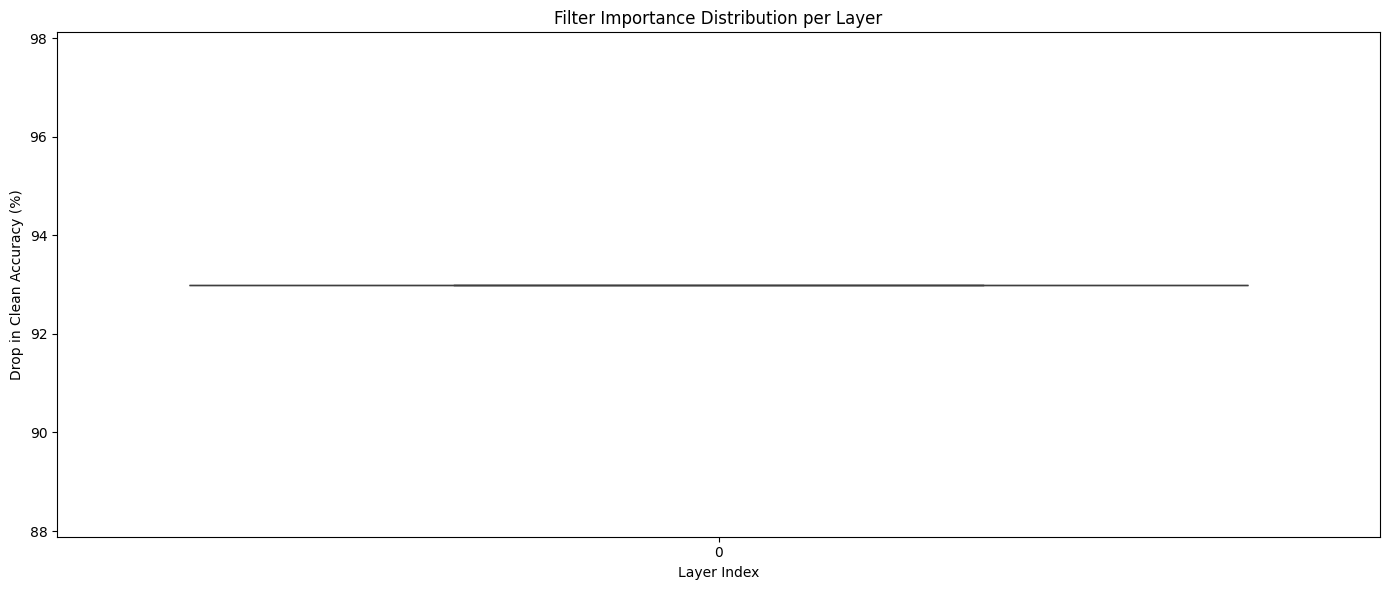

In [63]:
import seaborn as sns
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='Layer', y='DropInAcc')
plt.title("Filter Importance Distribution per Layer")
plt.xlabel("Layer Index")
plt.ylabel("Drop in Clean Accuracy (%)")
plt.tight_layout()
plt.show()

In [3]:
#inecting backdoors


In [ ]:
# Evaluate backdoor attack success
bdoor_acc = valid('Backdoor', X_bdoor, Y_bdoor, num_batches, objax.Jit(lambda x: model(x, training=False), train_vars))
print(f'Backdoor Attack Accuracy: {bdoor_acc:.2f}%')
print('Handcrafted Backdoor Attack Phase Completed.')

   [valid-Backdoor]: 100%|██████████| 157/157 [00:21<00:00,  7.40it/s]

Backdoor Attack Accuracy: 85.68%
Handcrafted Backdoor Attack Phase Completed.


## Evading Fine-Tuning Defense

In [ ]:
batch_size = 50
# Evaluate model before fine-tuning
predict = objax.Jit(lambda x: model(x, training=False), model.vars())

acc_clean_before = valid('N/A', X_test, Y_test, batch_size, predict, silient=True)
acc_bdoor_before = valid('N/A', X_bdoor, Y_bdoor, batch_size, predict, silient=True)

print(f" Before Fine-Tuning:")
print(f"  - Clean Accuracy: {acc_clean_before:.2f}%")
print(f"  - Backdoor Success Rate: {acc_bdoor_before:.2f}%")


 Before Fine-Tuning:
  - Clean Accuracy: 87.47%
  - Backdoor Success Rate: 80.24%


In [ ]:
batch_size = 50      
num_tunes = 5      
learning_rate = 0.025 
backdoor_label = 0   # Target label for backdoor
backdoor_size = 4    # Trigger size

# loss function
def loss_fn(x, y):
    logits = model(x, training=True)
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).mean()

# Define optimizer and gradient update
train_vars = objax.VarCollection(model.vars())
gv = objax.GradValues(loss_fn, train_vars)
optimizer = objax.optimizer.SGD(train_vars)

def fine_tune_step(x, y, lr):
    g, v = gv(x, y)
    optimizer(lr=lr, grads=g)
    return v

fine_tune_step = objax.Jit(fine_tune_step, gv.vars() + optimizer.vars())

In [72]:
# # Run Fine-Tuning
# for epoch in range(num_tunes):
#     train_loss = train(epoch, X_train, Y_train, batch_size, fine_tune_step, learning_rate)
    
#     acc_clean_after = valid('N/A', X_test, Y_test, batch_size, predict, silient=True)
#     acc_bdoor_after = valid('N/A', X_bdoor, Y_bdoor, batch_size, predict, silient=True)

#     print(f" Fine-Tune Epoch {epoch+1}/{num_tunes}")
#     print(f"  - Clean Accuracy: {acc_clean_after:.2f}%")
#     print(f"  - Backdoor Success Rate: {acc_bdoor_after:.2f}%")
#     print(f"  - Training Loss: {train_loss:.4f}")

In [ ]:
# Save Fine-Tuned Model
save_path = f"models/{dataset}/{network}/fine_tuned_model_cifar10.npz"
save_network_parameters(model, save_path)
print(f"Fine-tuned model saved to {save_path}.")

Fine-tuned model saved to models/cifar10/ResNet18/fine_tuned_model_cifar10.npz.


### Evading Neural Cleanse: Visualization of Attack Success

In [ ]:
# Function to run Neural Cleanse and backdoor success evaluation
def run_neural_cleanse(a,b ,c):
    pass

def compute_nc_evasion_results(model, x_valid, y_valid, trigger_sizes):

    nc_detect_rates = []
    backdoor_success_rates = []

    for size in trigger_sizes:
        print(f"▶ Evaluating trigger size {size} pixels...")

        # Inject backdoor trigger and test attack success
        x_backdoor, y_backdoor = blend_backdoor(x_valid, y_valid, size)
        backdoor_success = valid('Backdoor', x_backdoor, y_backdoor, batch_size=50, predict=model)

        # Run Neural Cleanse to detect the backdoor
        nc_detect = run_neural_cleanse(a,b ,c )

        # Store results
        backdoor_success_rates.append(backdoor_success * 100)
        nc_detect_rates.append(nc_detect * 100)  

        print(f"  - Backdoor Success: {backdoor_success * 100:.2f}%")
        print(f"  - NC Detection Rate: {nc_detect * 100:.2f}%")

    return nc_detect_rates, backdoor_success_rates

# List of trigger sizes in pixels
_size_xaxis = [4, 8, 12, 16, 20, 24, 28]

# Compute results using your model
_size_ncres, _size_succs = compute_nc_evasion_results(model, x_valid, y_valid, _size_xaxis)

# Print final results
print("\nFinal Results:")
for i, size in enumerate(_size_xaxis):
    print(f"Trigger Size {size}: NC Detection { _size_ncres[i]}%, Backdoor Success {_size_succs[i]}%")


######################################################################################################
# Disable warnings for cleaner output
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set seaborn configurations for better visualization
_sns_configs = {
    'font.size': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.0,
    'axes.labelsize': 16,
    'legend.facecolor': 'white',
    'legend.edgecolor': 'black',
    'legend.fontsize': 16,
    'grid.color': '#c0c0c0',
    'grid.linestyle': ':',
    'grid.linewidth': 0.8,
}
sns.set_theme(rc=_sns_configs)
#########################################################################################################
# Manually Collected Neural Cleanse (NC) Evasion Data
_size_xaxis = [4, 8, 12, 16, 20, 24, 28]  # Width of trigger patterns
_size_ncres = [100, 100, 10, 0, 0, 0, 0]  # Neural Cleanse detection rate (%)
_size_succs = [100, 100, 98, 100, 100, 100, 100]  # Backdoor success rate (%)

# Accuracy distribution based on trigger size
_size4_accs = [
    [0, 10, 20, 30, 40, 52, 61, 72, 89, 100],  # Backdoor success rate
    [0, 0, 0, 0, 0, 0, 60, 100, 100, 100],    # Neural Cleanse detection rate
]

_size8_accs = [
    [0, 10, 20, 30, 40, 50, 60, 70, 80, 93, 96, 98, 100],  # Backdoor success rate
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 60, 100],          # Neural Cleanse detection rate
]

_markers = ['o', 'v', 'p', '*', 'x']
_linestyles = [':', '-.', '--', '-']


# Create and Save Neural Cleanse Evasion Plots

# Set the storage directory
save_rdir = os.path.join("analysis", "NC")
os.makedirs(save_rdir, exist_ok=True)


# Plot 1: NC Detection Rate vs. Trigger Size
plt.figure(figsize=(9, 3.4))

sns.lineplot(
    x=np.array(_size_xaxis), y=np.array(_size_ncres),
    marker=_markers[0], markeredgecolor='r',
    linestyle=_linestyles[0], color='r', label='NC success'
)

sns.lineplot(
    x=np.array(_size_xaxis), y=np.array(_size_succs),
    marker=_markers[1], markeredgecolor='k',
    linestyle=_linestyles[1], color='k', label='Backdoor success'
)

plt.xlim(min(_size_xaxis), max(_size_xaxis))
plt.xticks(_size_xaxis + [4.])
plt.xlabel("Trigger Pattern Width (pixels)")
plt.ylim(-1, 101)
plt.yticks(range(0, 120, 20))
plt.ylabel("NC Detection Rate (%)")
plt.legend()

plot_filename = os.path.join(save_rdir, "nc_detection_vs_trigger_size.png")
plt.tight_layout()
plt.savefig(plot_filename)
plt.show()

print(" Plot 1: NC Detection Rate vs. Trigger Size saved successfully.")


# Plot 2: Backdoor Success Rate vs. NC Detection
plt.figure(figsize=(9, 3.4))

sns.lineplot(
    x=np.array(_size4_accs[0]), y=np.array(_size4_accs[1]),
    marker=_markers[0], markeredgecolor='b',
    linestyle=_linestyles[0], color='b', label="4x4 Trigger"
)

sns.lineplot(
    x=np.array(_size8_accs[0]), y=np.array(_size8_accs[1]),
    marker=_markers[1], markeredgecolor='k',
    linestyle=_linestyles[1], color='k', label="8x8 Trigger"
)

plt.xlim(0, 100)
plt.xlabel("Backdoor Success Rate (%)")
plt.ylim(-1, 101)
plt.yticks(range(20, 120, 20))
plt.ylabel("NC Detection Rate (%)")
plt.legend(loc="upper left")

plot_filename = os.path.join(save_rdir, "nc_detection_vs_success_rate.png")
plt.tight_layout()
plt.savefig(plot_filename)
plt.show()

print("Plot 2: Backdoor Success Rate vs. NC Detection saved successfully.")

# Completed
print("Neural Cleanse evasion plots generated successfully!")
